---
title: Spectral Tree Theory
author: Benjamin Doran
date: Dec 2023
---

In [13]:
#| code-fold: true
#| code-summary: Julia Setup
using DrWatson
@quickactivate projectdir()

using SpectralInference # custom package from $projectdir/src
using NewickTree
using Gotree_jll, Goalign_jll
using StatsBase, NeighborJoining
using Distances, Clustering
using DataFrames, CSV
using Muon
using Symbolics
using StatsPlots
theme(:default, grid=false, label=false, tickdir=:out)
using LinearAlgebra
using LaTeXStrings
include(srcdir("helpers.jl"))
heatmapcols = [:purple, :black, :yellow];
generationcols = ["#B3D2FC" "#2B689E" "#338591"];

## Exploration of toy evolution

To explore if genomic distance can be inferred from covariation patterns  We start with an in *silico* model of sequential diversification. A ancestral root is defined by 13-bit string of ‘1’. Diversification through three generations creates an alignment of eight ‘taxa’. Colored bits in the alignment match the color of generation ‘G1’, ‘G2’, or ‘G3’ at which variation from a ‘1’ to ‘0’ was created.

In [3]:
# note how the zeros creates 3 layers of bifurcations
M = Float64.([
    0 1  0 1 1 1  0 1 1 1 1 1 1 1;
    0 1  0 1 1 1  1 0 1 1 1 1 1 1;
    0 1  1 0 1 1  1 1 0 1 1 1 1 1;
    0 1  1 0 1 1  1 1 1 0 1 1 1 1;
    1 0  1 1 0 1  1 1 1 1 0 1 1 1;
    1 0  1 1 0 1  1 1 1 1 1 0 1 1;
    1 0  1 1 1 0  1 1 1 1 1 1 0 1;
    1 0  1 1 1 0  1 1 1 1 1 1 1 0;
]);

In [4]:
usv = svd(M);

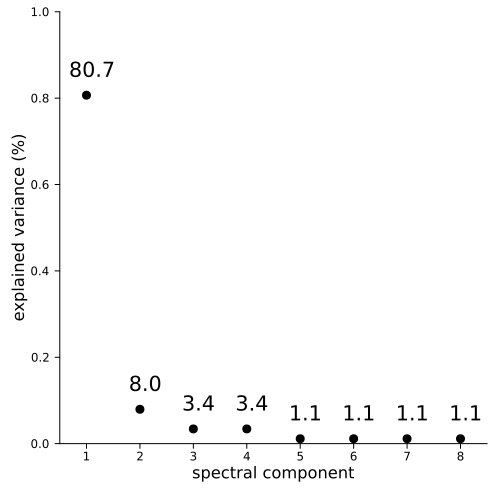

In [5]:
plot(
    ylabel="explained variance (%)", 
    xlabel="spectral component", 
    legend=:none, 
    ylims=(0,1), xlims=(.5,8.5), 
    size=(500,500)
)
scatter!((usv.S.^2)/sum(usv.S.^2), 
    xticks=1:14, c=:black, markersize=5,
)
annotate!((1:length(usv.S)) .+ .1 , (usv.S.^2)/sum(usv.S.^2).+.06, round.((usv.S.^2)/sum(usv.S.^2)*100, digits=1))

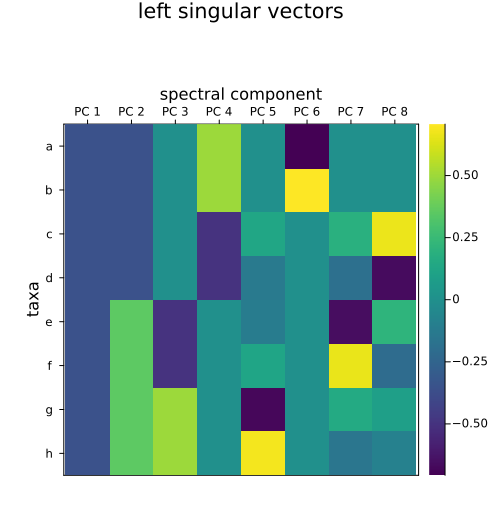

In [6]:
heatmap(usv.U, 
    c=:viridis,
    framestyle=:box,
    ratio=1,
    xmirror=true,
    yflip=true,
    yticks=(1:8, 'a':'h'),
    xticks=(1:8, ["PC $i" for i in 1:8]),
    margin=5Plots.mm,
    size=(500,530),
    xlabel="spectral component",
    ylabel="taxa",
    title="left singular vectors",
)

In [7]:
# calculate euclidean distance between each taxa-taxa pair on each left singular vector
spires = spectraldistances_trace(usv.U, usv.S, [i:i for i in 1:8])
# cumulative sum of distances for each pair along each LSV
spires = mapslices(cumsum, spires, dims=1)

# masks of pairs that diverged only at <xx> generation
trilmask = tril(trues(size(usv.U)),-1)
G1mask = Bool.(kron([0 0; 1 0],[1 1;1 1], [1 1;1 1]))
G2mask = Bool.(kron([1 0; 0 1], [0 0; 1 0], [1 1; 1 1]))
G3mask = Bool.(kron([1 0; 0 1],[1 0; 0 1], [0 0; 1 0]));

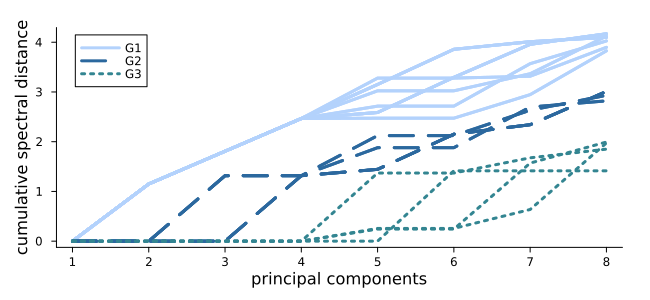

In [8]:
#| fig-cap: note that all pairs that diverged at G1 (e.g. 'a' and 'h') have a positive distance at component 2; 
plot([0 0 0], 
    label=["G1" "G2" "G3"], 
    c=generationcols,
    linestyle=[:solid :dash :dot],
    linewidth=3,
    size=(650, 300),
    legend=:topleft,
    xticks=1:8,
    ylabel="cumulative spectral distance",
    xlabel="principal components",
    margin=5Plots.mm,
)
plot!(spires[:, G1mask[trilmask]],linewidth=3, c=generationcols[1],linestyle=:solid, label="")
plot!(spires[:, G2mask[trilmask]],linewidth=3, c=generationcols[2],linestyle=:dash,  label="")
plot!(spires[:, G3mask[trilmask]],linewidth=3, c=generationcols[3],linestyle=:dot,   label="")

In [9]:
partitioneddists = spectraldistances_trace(usv.U, usv.S, [1:1, 2:2, 3:4, 5:8])
cumsumpdists = cumsum(partitioneddists, dims=1);

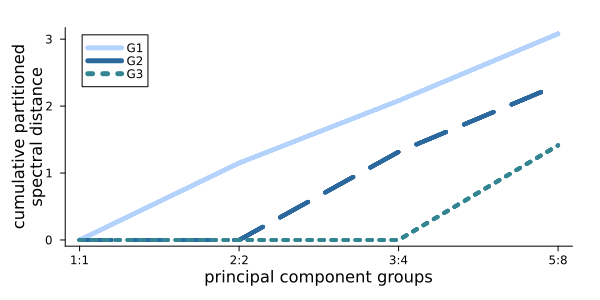

In [10]:
plot([0 0 0], 
    label=["G1" "G2" "G3"], 
    c=generationcols,
    linestyle=[:solid :dash :dot],
    legend=:topleft,
    linewidth=5,
    size=(600, 300),
    xticks=(1:4, ["1:1", "2:2", "3:4", "5:8"]),
    ylabel="cumulative partitioned\nspectral distance",
    xlabel="principal component groups",
    margin=5Plots.mm,
)
plot!(cumsumpdists[:, G1mask[trilmask]], linewidth=4, c=generationcols[1],linestyle=:solid, label="")
plot!(cumsumpdists[:, G2mask[trilmask]], linewidth=4, c=generationcols[2],linestyle=:dash,  label="")
plot!(cumsumpdists[:, G3mask[trilmask]], linewidth=4, c=generationcols[3],linestyle=:dot,   label="")

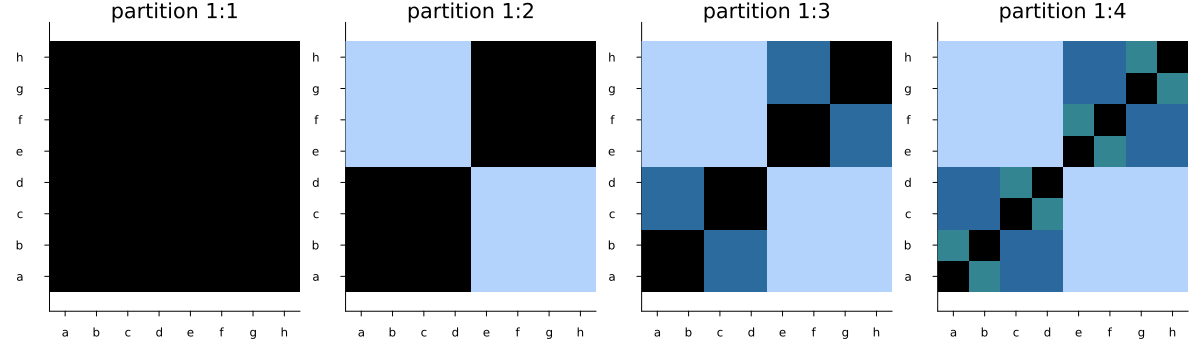

In [11]:
## Plot partitioned distance matrix (Partitioned Weighted Euclidean)
colors = [:black, reverse(generationcols)...]
plot(layout=grid(1,4), size=(1200, 350), ratio=1, colorbar=:none, bottommargin=5Plots.Measures.mm, ticks=(1:8, 'a':'h'))
heatmap!(trunc.(squareform(cumsumpdists[1,:]), digits=13), sp=1, c=colors, title="partition 1:1", leftmargin=5Plots.mm,)
heatmap!(squareform(cumsumpdists[2,:]), sp=2, c=colors, title="partition 1:2")
heatmap!(squareform(cumsumpdists[3,:]), sp=3, c=colors, title="partition 1:3")
heatmap!(trunc.(Int,squareform(cumsumpdists[4,:])), sp=4, c=colors, title="partition 1:4")

In [12]:
# sum of all partitioned distances
dij = squareform(cumsumpdists[4,:])

8×8 Matrix{Float64}:
 0.0      1.41421  2.31607  2.31607  3.08077  3.08077  3.08077  3.08077
 1.41421  0.0      2.31607  2.31607  3.08077  3.08077  3.08077  3.08077
 2.31607  2.31607  0.0      1.41421  3.08077  3.08077  3.08077  3.08077
 2.31607  2.31607  1.41421  0.0      3.08077  3.08077  3.08077  3.08077
 3.08077  3.08077  3.08077  3.08077  0.0      1.41421  2.31607  2.31607
 3.08077  3.08077  3.08077  3.08077  1.41421  0.0      2.31607  2.31607
 3.08077  3.08077  3.08077  3.08077  2.31607  2.31607  0.0      1.41421
 3.08077  3.08077  3.08077  3.08077  2.31607  2.31607  1.41421  0.0

In [13]:
ntree = SpectralInference.newickstring(UPGMA_tree(dij), string.('a':'h'))

"(((d:1.414214e+00,c:1.414214e+00):9.018605e-01,(b:1.414214e+00,a:1.414214e+00):9.018605e-01):7.646942e-01,((e:1.414214e+00,f:1.414214e+00):9.018605e-01,(h:1.414214e+00,g:1.414214e+00):9.018605e-01):7.646942e-01):0.000000e+00;"

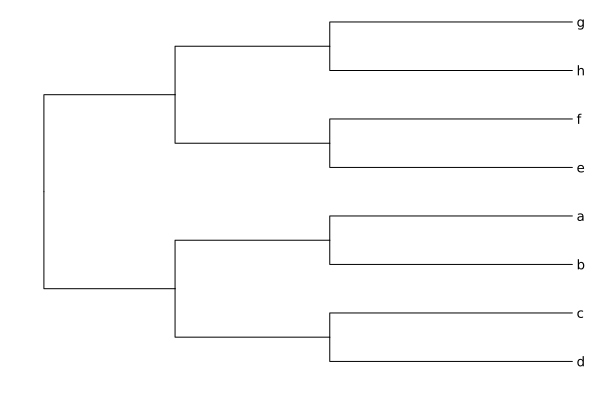

In [14]:
plot(readnw(ntree))

In [15]:
# unrooted but same topology
ntree = NeighborJoining.newickstring(regNJ(dij), string.('a':'h'))

"(((b:7.071068e-01,a:7.071068e-01):4.509302e-01,((f:7.071068e-01,e:7.071068e-01):4.509302e-01,(h:7.071068e-01,g:7.071068e-01):4.509302e-01):7.646942e-01):2.254651e-01,(d:7.071068e-01,c:7.071068e-01):2.254651e-01):0.000000e+00;"

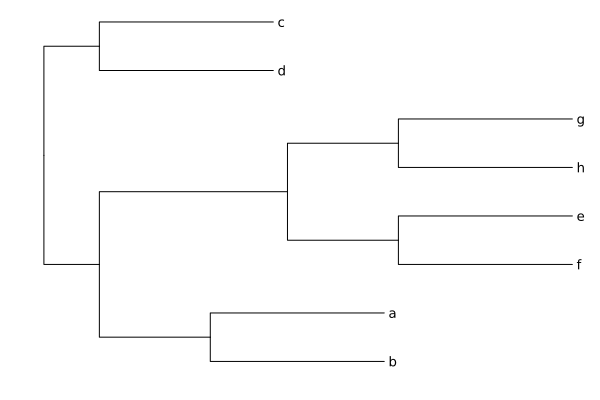

In [16]:
plot(readnw(ntree))

### Standard phylogenetic tools

In [16]:
using Goalign_jll
using Gotree_jll
toyMSA_8x14_dir = datadir("sims", "toyMSA_8x14") |> mkpath

# write out alignment
writephylip(
    joinpath(toyMSA_8x14_dir, "MSA.phylip"),
    join.(eachrow((replace(M, 0.0 => 'A', 1.0 => 'T')))),
    collect('a':'h')
)

In [22]:
# FastME
run(`julia $(projectdir("scripts", "runners", "runFastME.jl")) 
    -i $(datadir("sims", "toyMSA_8x14", "MSA.phylip"))
    -o $(projectdir("_research", "toyMSA_8x14", "FastME"))
    -m JC69
`)
# PhyML
run(`julia $(projectdir("scripts", "runners", "runPhyML.jl")) 
    -i $(datadir("sims", "toyMSA_8x14", "MSA.phylip"))
    -o $(projectdir("_research", "toyMSA_8x14", "PhyML"))
    -m JC69
`)
# # RAxML (needs intel chip)
# run(`julia $(projectdir("scripts", "runners", "runRAxML.jl")) 
#     -i $(datadir("sims", "toyMSA_8x14", "MSA.phylip"))
#     -o $(projectdir("_research", "toyMSA_8x14", "RAxML"))
#     -m JC69
# `)
# MrBayes
run(`julia $(projectdir("scripts", "runners", "runMrBayes.jl")) 
    -i $(datadir("sims", "toyMSA_8x14", "MSA.phylip"))
    -o $(projectdir("_research", "toyMSA_8x14", "MrBayes"))
    -m JC69
`);
# SpectralInference
run(`julia $(projectdir("scripts", "runners", "runSPI.jl")) 
    -i $(datadir("sims", "toyMSA_8x14", "MSA.phylip"))
    -o $(projectdir("_research", "toyMSA_8x14", "SPI"))
    -m JC69
`);

  Activating

 project at `~/projects/Doran_etal_2023`


[ Info: Starting FastME on MSA


[ Info: using Booster to compute support values


[ Info: stopping run


 ──────────────────────────────────────────────────────────────────────
                              Time                    Allocations      
                     ───────────────────────   ────────────────────────
  Tot / % measured:       560ms /  91.0%           51.6MiB /  89.7%    

 Section     ncalls     time    %tot     avg     alloc    %tot      avg
 ──────────────────────────────────────────────────────────────────────
 total            1    509ms  100.0%   509ms   46.3MiB  100.0%  46.3MiB
   booster        1    219ms   43.1%   219ms   1.16MiB    2.5%  1.16MiB
   FastME         1    142ms   27.9%   142ms   3.29MiB    7.1%  3.29MiB
 ──────────────────────────────────────────────────────────────────────
┌ Info: timing
│   show(time) = nothing
└   println("") = nothing


  Activating

 project at `~/projects/Doran_etal_2023`


[ Info: Starting PhyML on MSA


[ Info: stopping run
 ────────────────────────────────────────────────────────────────────
                            Time                    Allocations      
                   ───────────────────────   ────────────────────────
 Tot / % measured:      277ms /  82.2%           50.1MiB /  89.4%    

 Section   ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────
 total          1    228ms  100.0%   228ms   44.8MiB  100.0%  44.8MiB
   PhyML        1   98.4ms   43.2%  98.4ms   2.97MiB    6.6%  2.97MiB
 ────────────────────────────────────────────────────────────────────
┌ Info: timing
│   show(time) = nothing
└   println("") = nothing


  Activating

 project at `~/projects/Doran_etal_2023`


[ Info: Converting input to nexus format
[ Info: changing dir to: /Users/bend/projects/Doran_etal_2023/_research/toyMSA_8x14/MrBayes


[ Info: changing dir to: /Users/bend/projects/Doran_etal_2023/notebooks
[ Info: stopping run
 ────────────────────────────────────────────────────────────────────────────────
                                        Time                    Allocations      
                               ───────────────────────   ────────────────────────
       Tot / % measured:            12.3s /  99.6%           63.3MiB /  91.6%    

 Section               ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────────────────
 total                      1    12.2s  100.0%   12.2s   58.0MiB  100.0%  58.0MiB
   mrbayes                  1    12.1s   98.5%   12.1s   12.4MiB   21.3%  12.4MiB
   convert input to...      1   29.4ms    0.2%  29.4ms   2.66MiB    4.6%  2.66MiB
   convert tree file        1   25.0ms    0.2%  25.0ms   1.17MiB    2.0%  1.17MiB
 ────────────────────────────────────────────────────────────────────────────────
┌ In

  Activating

 project at `~/projects/Doran_etal_2023`


[ Info: Starting SPI inference


[ Info: Setting up workspace
[ Info: Running SPI


[ Info: Writing out SPI Tree
[ Info: Starting Bootstrap with 100


[ Info: Writing out Bootstrap trees
[ Info: using Booster to compute support values


[ Info: Finishing run


 ────────────────────────────────────────────────────────────────────────────────
                                        Time                    Allocations      
                               ───────────────────────   ────────────────────────
       Tot / % measured:            1.48s /  96.1%            285MiB /  97.9%    

 Section               ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────────────────
 total                      1    1.42s  100.0%   1.42s    279MiB  100.0%   279MiB
   running SPI              1    820ms   57.9%   820ms    163MiB   58.3%   163MiB
   running bootstra...      1    162ms   11.4%   162ms   61.3MiB   22.0%  61.3MiB
 ────────────────────────────────────────────────────────────────────────────────
┌ Info: 
│ timing
│   show(time) = nothing
└   println("") = nothing


In [24]:
pdir_toyMSA_8x14 = plotsdir("toyMSA_8x14") |> mkpath

"/Users/bend/projects/Doran_etal_2023/plots/toyMSA_8x14"

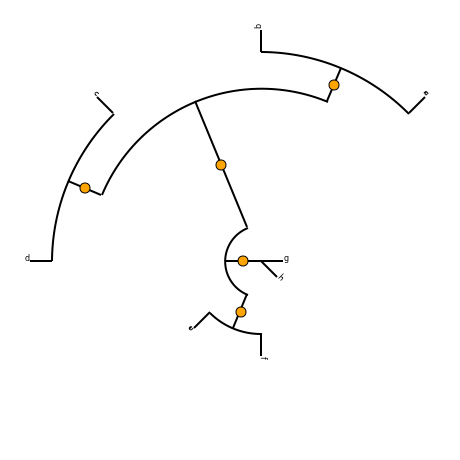

In [43]:
method = "FastME"
run(pipeline(`$(gotree()) draw svg -c -w 400 -H 400 --support-cutoff .5 --with-branch-support`,
    stdin=projectdir("_research", "toyMSA_8x14", method, "MSA-supporttree.nw"),
    stdout=joinpath(pdir_toyMSA_8x14, method * ".svg")
))
show_svg(joinpath(pdir_toyMSA_8x14, method * ".svg"))

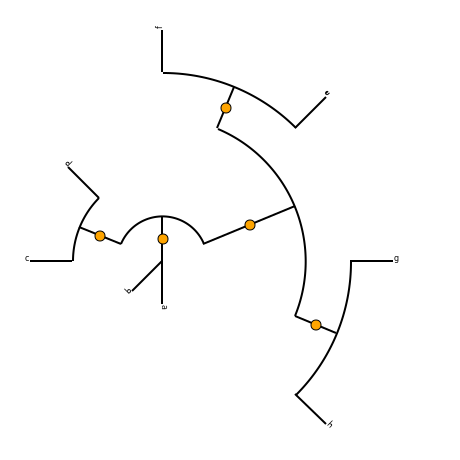

In [42]:
method = "PhyML"
run(pipeline(`$(gotree()) draw svg -c -w 400 -H 400 --support-cutoff .5 --with-branch-support`,
    stdin=projectdir("_research", "toyMSA_8x14", method, "MSA.phylip-supporttree.txt"),
    stdout=joinpath(pdir_toyMSA_8x14, method * ".svg")
))
show_svg(joinpath(pdir_toyMSA_8x14, method * ".svg"))

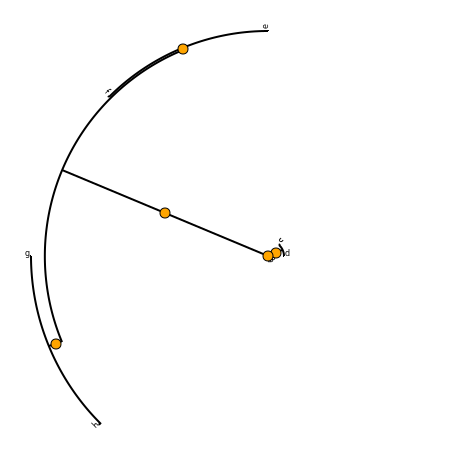

In [40]:
method = "RAxML"
run(pipeline(`$(gotree()) draw svg -c -w 400 -H 400 --support-cutoff .5 --with-branch-support`,
    stdin=projectdir("_research", "toyMSA_8x14", method, "$method-supporttree.nw"),
    stdout=joinpath(pdir_toyMSA_8x14, method * ".svg")
))
show_svg(joinpath(pdir_toyMSA_8x14, method * ".svg"))

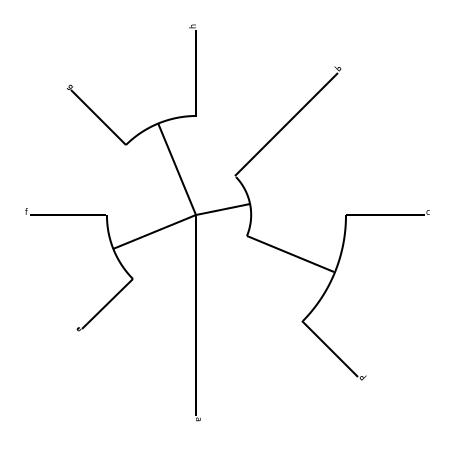

In [41]:
method = "MrBayes"
run(pipeline(`$(gotree()) draw svg -c -w 400 -H 400 --support-cutoff .5 --with-branch-support`,
    stdin=projectdir("_research", "toyMSA_8x14", method, "MSA-supporttree.nw"),
    stdout=joinpath(pdir_toyMSA_8x14, method * ".svg")
))
show_svg(joinpath(pdir_toyMSA_8x14, method * ".svg"))

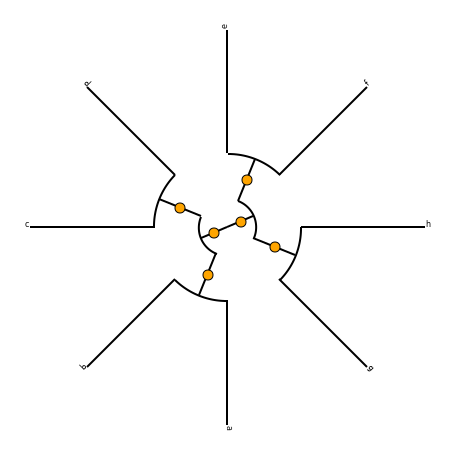

In [44]:
method = "SPI"
run(pipeline(`$(gotree()) draw svg -c -w 400 -H 400 --support-cutoff .5 --with-branch-support`,
    stdin=projectdir("_research", "toyMSA_8x14", method, "MSA-supporttree.nw"),
    stdout=joinpath(pdir_toyMSA_8x14, method * ".svg")
))
show_svg(joinpath(pdir_toyMSA_8x14, method * ".svg"))

## Understanding SVD math

### How similarity and dissimilarity are encoded into spectral components

We sought to understand the mathematics of why spectral factorization reveals hierarchical scales of relatedness. In answer, we found it is because the similarity and differences between sub-populations are split across separate spectral components. Specifically, we show that (i) an ensemble of systems with two sub-populations will have exactly 2 irreducible spectral components up to the exact point at which those populations become identical; (ii) the change in magnitude for these spectral components — their eigenvalues — are equal and opposite to each other as we increase the degree of relatedness between the sub-populations; and (iii) the major eigenvector encodes the similarity of the sub-populations and the lesser eigenvector encodes the sub-population's dissimilarity for all points between the extrema where the sub-populations are identical or completely independent.

As it is not guaranteed that the reader has a background in the required mathematics, we will split this section into two parts. Section §4.1 will delve into the necessary detail regarding eigenvalue decomposition, the determinant, and the characteristic polynomial for readers to understand the connections between these concepts. Section §4.2 will detail a specific case of an ensemble of 3 systems, and show how changing the degree of relatedness between these systems changes specific aspects of the eigenspectrum.

### Linear Algebra Background

#### What are eigenvectors?

For readers unfamiliar with linear algebra, some of the early applications for eigen decomposition in the 1700s were developed to describe the linear transformations of physical systems (rotations, shifting, scaling, and shearing of rigid bodies) [^hawkins]. Of particular interest in these descriptions are the principle axes or "eigenvectors" of the transformation which are the only vectors that do not change direction during the transform. The eigenspectrum describes the complete set of axes "eigenvectors", and is defined as the non-zero solutions to this equation

$$
C\vec{v} = \lambda\vec{v}
$$ {#eq-eigenvectors}

[^hawkins]: Hawkins, T. Cauchy and the spectral theory of matrices. Historia Mathematica 2, 1–29 (1975).

In @eq-eigenvectors, $C$ is the linear transformation, represented as a matrix of real numbers; $\vec{v}$ is the eigenvector, represented as a list of real numbers; and $\lambda$ is the eigenvalue, a real number that shortens or lengthens the eigen vector.

:::{.callout-note collapse=false}
As an example, this is one specific case of @eq-eigenvectors. 

$$
\begin{bmatrix}2&0\\0&2\end{bmatrix}\begin{bmatrix}1\\1\end{bmatrix} = 2\begin{bmatrix}1\\1\end{bmatrix}
$$

We can see in performing the matrix multiplications that both of these expressions are equal to the vector $[2,2]^t$

$$
\begin{align}
\begin{bmatrix}2&0\\0&2\end{bmatrix}\begin{bmatrix}v_1\\v_2\end{bmatrix} &= \begin{bmatrix}(2\times v_1) + (0\times v_2)\\(0\times v_1)+(2\times v_2)\end{bmatrix} \\
&= \begin{bmatrix}(2\times 1) + (0\times1)\\(0\times1)+(2\times1)\end{bmatrix} \\
& = \begin{bmatrix}2\\2\end{bmatrix} \\
&= 2\begin{bmatrix}1\\1\end{bmatrix}
\end{align}
$$
:::

The eigenvectors and eigenvalues are useful precisely because they are the only stable descriptors of the transformation and can be used to consistently describe positions both before and after the transform.

To mathematically solve for these eigenvectors, one common technique is to first find the eigenvalues which are the solutions to @eq-eigenvalues, and then substitute these eigenvalues into @eq-eigenvectors and solve for each of the eigenvectors ($\vec{v}$). All applications of spectral factorization (i.e. SVD and PCA) use this fundamental equation to define their spectral components ('eigenvectors').

$$
\det(C - \lambda I) = 0
$$ {#eq-eigenvalues}

In @eq-eigenvalues, $C$ is again the linear transformation; $I$ is the identity matrix of the same size as $C$, defined as having $1$s along the diagonal and $0$ for all other entries; $det()$ is the determinant function which describes a change in the degrees of freedom or number of dimensions after a linear transformation; and $\lambda$ is the variable that we are trying to infer (i.e., $\lambda$ equals the eigenvalue when @eq-eigenvalues is true).

As we will see, @eq-eigenvalues can also be expressed as the "characteristic polynomial" of the transform.

$$
\det(\lambda I - C_{n\times n}) = \lambda^n - c_{n-1}\lambda^{n-1} + c_{n-2}\lambda^{n-2}  - c_{n-3}\lambda^{n-3}... = 0
$$ {#eq-charpoly}

The characteristic polynomial is a monic alternating sign polynomial of degree $n$ where $n$ is the minimum dimension of $C$. A monic polynomial means that the leading coefficient is always equal to $1$. And alternating sign means that the sign of each subsequent term alternates in sign from $+$ to $-$ and back. The roots of this polynomial, (i.e., the values of $\lambda$ that set it equal to zero) are the eigenvalues of @eq-eigenvalues. 

:::{.callout-note collapse=false}
Note the change from $\det(C - \lambda I)$ in @eq-eigenvalues to $\det(\lambda I - C)$ in @eq-charpoly.

This factor of $-1$ ensures that the characteristic polynomial is always expressed with a positive leading coefficient. The definition in @eq-eigenvalues, $\det(C - \lambda I)$ has a negative leading coefficient for any matrix $C$ with an odd number of rows and columns. 

It can be awkward to display the expansion of $\det(\lambda I - C)$, so we forgo showing the $-1$ factor in this document until the last step to finish with the canonical form of the characteristic polynomial.
:::

#### Rational for using $\det(C-\lambda I) = 0$
To fully intuit the logic behind for using the equation $\det(C-\lambda I) = 0$ to solve for eigenvalues, it will help to review how matrices in linear algebra describe transformation of space. 

If we multiply a vector $\vec{u}$ by a matrix $C$ we will get a new vector that may be pointing in a new direction $\vec{v}$. 

$$
C\vec{u} = \vec{v}
$$

To reiterate, there are special vectors for each matrix $C$ that do *not* change direction after the transformation -- $C\vec{v} = \lambda\vec{v}$. Instead they only change in magnitude. These are exactly the eigenvectors of the matrix, and the magnitude (length of the vector) $\lambda$ is the eigenvalue. These eigenvectors and values are particularly important for describing the transformation and describing how points move through the transformation because they are the only stable axes during the transformation.

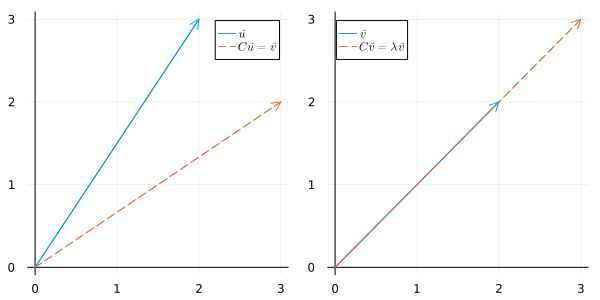

In [4]:
#| fig-cap: example of linear transformation on regular vector (left) versus an eigen vector of that transformation (right)
#| echo: false
#| label: fig-vectors
plot(framestyle=:zerolines, )
plot!([0, 2], [0, 3]; arrow=true, label=L"\vec{u}")
p1 = plot!([0, 3], [0, 2]; linestyle=:dash, arrow=true, label=L"C\vec{u} = \vec{v}")

plot(framestyle=:zerolines,)
plot!([0, 2], [0, 2]; arrow=true, label=L"\vec{v}")
p2 = plot!(1.5 * [0, 2], 1.5 *  [0, 2]; linestyle=:dash, arrow=true, label=L"C\vec{v} = \lambda \vec{v}")
plot(p1, p2; link=:y, size=(600, 300), grid=true)

To solve for the eigenvectors we can do some algebraic manipulations to factor out $\vec{v}$ within @eq-eigenvectors

$$
\begin{align}
    C\vec{v} &=  \lambda\vec{v} \\
    C\vec{v} - \lambda\vec{v} &= 0 \\
    C\vec{v} - \lambda I \vec{v} &= 0 \\
    (C - \lambda I )\vec{v} &= 0 \\
\end{align}
$$


After these manipulations we have the eigenvector $\vec{v}$ multiplied by $(C - \lambda I)$ a matrix of our original transform $C$ subtracting out the eigenvalue on the diagonal.

:::{.callout-note collapse=false}
Expanding at this stage would show this form:

$$
    (C - \lambda I)\vec{v} = \begin{bmatrix}
    c_{1,1} - \lambda&\cdots&c_{1,n} \\
    \vdots&\ddots&\vdots \\
    c_{n,1}&\cdots&c_{n,n}- \lambda\\
    \end{bmatrix} \begin{bmatrix}v_1\\\vdots\\v_n\end{bmatrix} = 0
$$

:::

Notice that making $\vec{v}$ equal to the zero vector is a trivial solution for all matrices. Because this solution is true for all matrices, eigenvectors are generally defined as only the non-zero solutions to @eq-eigenvectors. 

So when is $\vec{v}$ non-zero, and yet multiplying by $(C - \lambda I)$ results in zero? Our prior manipulations were useful for answering this question because they let us play a quick thought experiment. Lets take a moment to assume that $(C - \lambda I)$ is invertible. Invertible means that there exists some matrix $(C - \lambda I)^{-1}$ that would completely reverse the transformation and place every vector back where it started, (i.e., the transformation matrix is canceled by its inverse transformation). So $(C - \lambda I)^{-1}(C - \lambda I) = I$ the identity matrix because for any matrix $\cancel{A^{-1}A}\vec{v} = I\vec{v} = \vec{v}$. 

If we place this inverse into the eigenvector equation from before we see that if $(C - \lambda I)$ is invertible than $\vec{v}$ **must** equal the zero vector. 

$$
\begin{align}
        (C - \lambda I)\vec{v} &= 0 \\
        (C - \lambda I)^{-1} (C - \lambda I)\vec{v} &= (C - \lambda I)^{-1}0 \\
    I\vec{v} &= 0 \\
    \vec{v} &= 0 \\
\end{align}
$$

From this thought experiment we see that for $\vec{v}$ to be non-zero $(C - \lambda I)$ must be non-invertible. A matrix being non-invertible essentially means that at least 2 vectors are placed in the same location after the transformation $A\vec{u} = A\vec{w}$. In geometric terms, we can think of this as an reduction in dimensionality; a line being compressed into a single point, a plane being compressed into a line or point. 

We can then interpret our search for eigenvalues as searching for intrinsic scales of dimensionality. We can expand a sphere from the origin and at particular radii we are canceling out dimensional axes, i.e. for particular values of $\lambda$ we are subtracting the full magnitude of a principal axis in our observed data which flattens all observations along that axis to zero.

The determinant function is how we measure this collapse of dimensionality. In the 2 dimensional case,the geometric interpretation behind the determinant is that it measures the area of the unit square after a transformation by matrix $C$. If the transform $C$ compresses all the points in the area of the unit square onto a single line or point, (a) the area of the unit square after the transform equals zero $\det(C)=0$, (b) this transform is not invertible. The transform is not invertible because multiple points are moved onto the same coordinate by the transform, and so to move every point back to its original location would require information lost by the transform. The determinant is used for finding eigenvalues because it is the exact measure of when a transform is non-invertible (i.e. has a loss of dimensionality).

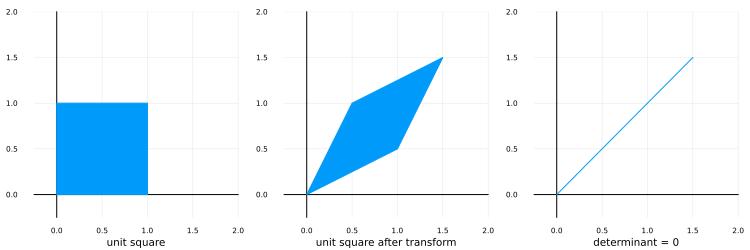

In [7]:
#| echo: false
#| fig-cap: example of unit square after different linear transforms. The last case (right) shows example of the 2d plane being compressed to a single line at which point the determinant equals zero
#| label: fig-2d-determinant
plot(framestyle=:zerolines, lims=(-.25, 2))
p1 = plot!([(0, 0), (0, 1), (1,1), (1, 0), (0,0)]; 
    fill=0, 
    xlabel="unit square",
    label="",
)

plot(framestyle=:zerolines, lims=(-.25, 2), legend=:topright)
p2 = plot!([(0, 0), (.5, 1), (1.5,1.5), (1, .5), (0,0)];
     fill=0, 
     xlabel="unit square after transform",
     label="",
)

plot(framestyle=:zerolines, lims=(-.25, 2), legend=:topright)
p3 = plot!([(0, 0), (.5, .5), (1.5,1.5), (.5, .5), (0,0)];
    fill=0, 
    xlabel="determinant = 0",
    label="",
)
plot(p1, p2, p3; link=:y, layout=grid(1,3), 
    grid=true,
    size=(750, 250),
    tickfontsize=5, 
    xlabelfontsize=7, 
    bottommargin=2Plots.Measures.mm)

### The determinant defined

Analytically, the determinant of a 2 x 2 matrix is defined as:

$$
\det{\begin{pmatrix} a & b \\ c & d \end{pmatrix}} = \begin{vmatrix} a & b \\ c & d \end{vmatrix} = ad - bc
$$

And it is defined recursively for larger matrices.

$$
\det(C_{n\times n}) = \sum_{j=1}^n \sigma_j C_{1,j} \det(C_{-1, -j})
$$ {#eq-recursivedeterminant}

where $\sigma_j$ is defined as $+1$ if $j$ is odd and $-1$ if $j$ is even; $C_{-1, -i}$ is an $n-1 \times n-1$ matrix made by removing the first row and $j$th column. 

For example, here is the first layer of recursion for a 3 x 3 matrix, which is defined as an alternating sum of 2 x 2 determinants weighted by each complementary element of the top row.

$$
\left|\begin{array}{ccc}
    a & b & c \\
    d & e & f \\
    g & h & i \\
\end{array}\right| \\
= a\left|\begin{array}{cc}e&f\\h&i\end{array}\right| -
    b\left|\begin{array}{cc}d&f\\g&i\end{array}\right| +
    c\left|\begin{array}{cc}d&e\\g&h\end{array}\right|
$$

Expanded fully, the determinant forms a sum of $n$ factorial ($n!$) products where $n$ is the number of columns in the matrix.

$$
aei - afh - bdi + bfg + cdh - ceg
$$

### The relationship between determinant and characteristic polynomial

When all elements of the matrix are known, this sum of products collapses down to a single number: the result of the determinant. When there is an unknown variable in the matrix, like with with our eigenvalue problem in @eq-eigenvalues, the determinant instead collapses to a polynomial of the unknown variable. This polynomial is the characteristic polynomial of the matrix.

As we can show with a 3x3 example:

$$
\begin{align}
0 &= \det(C - \lambda I) \\
&= \left|\begin{array}{ccc}
    a - \lambda & b & c \\
    d & e - \lambda & f \\
    g & h & i - \lambda \\
\end{array}\right| \\
&= (a - \lambda)\left|\begin{array}{cc}e - \lambda&f\\h&i - \lambda\end{array}\right| -
    b\left|\begin{array}{cc}d&f\\g&i - \lambda\end{array}\right| +
    c\left|\begin{array}{cc}d&e - \lambda\\g&h\end{array}\right|
\end{align}
$$

When expanded into the alternating sum of $n!$ terms we see that some of these terms have more instances of $\lambda$ than others

$$
(a - \lambda)(e - \lambda)(i - \lambda) - (a - \lambda)fh - bd(i - \lambda) + bfg + cdh - c(e - \lambda)g
$$

We can sort by the number of instances of $\lambda$

$$
(a - \lambda)(e - \lambda)(i - \lambda) - fh(a - \lambda) - bd(i - \lambda) - cg(e - \lambda) + bfg + cdh
$$

To continue, let's make this more specific and take it term by term. 

For this example we will use the matrix 

$$
C = \begin{bmatrix}1&1&1\\1&1&1\\1&1&1\end{bmatrix}
$$

So for this first term we can expand 

$$
\begin{align}
(a - \lambda)(e - \lambda)(i - \lambda) &= (1 - \lambda)(1 - \lambda)(1 - \lambda) \\
&= -\lambda^3 + 3\lambda^2 - 3\lambda + 1
\end{align}
$$

for the second, third, and fourth terms we get 

$$
\begin{align}
-fh(a - \lambda) &= \\
-bd(i - \lambda) &= \\
-cg(e - \lambda) &= \\
-(1\times 1)(1 - \lambda) &= \lambda - 1
\end{align}
$$

and our fifth and sixth terms both equal $+1$.

$$bfg = cdh = 1\cdot 1 \cdot 1 =  1$$

Putting them together we get

$$
\begin{align}
&(-\lambda^3 + 3\lambda^2 - 3\lambda + 1) + (\lambda - 1) + (\lambda - 1) + (\lambda - 1) + 1 + 1  \\
&= -\lambda^3 + 3\lambda^2 - 3\lambda + \lambda + \lambda + \lambda - 1 - 1 - 1 + 1 + 1 + 1 \\
&= -\lambda^3 + 3\lambda^2 - 3\lambda + 3\lambda + 3 - 3 \\
&= -\lambda^3 + 3\lambda^2
\end{align}
$$

To finish, we multiply by -1 to get the canonical form of the characteristic polynomial because the characteristic polynomial is technically defined by $\det(\lambda I - C )$ rather than $\det(C - \lambda I)$

$$
\det(\lambda I - C) = \lambda^3 - 3\lambda^2 \text{ when } C = \begin{bmatrix}1&1&1\\1&1&1\\1&1&1\end{bmatrix}
$$


What we have described so far is that (i) eigenvectors are the stable principal axes of linear transformations; (ii) The determinant is used to solve for eigenvalues (and by proxy eigenvectors) because it measures when a principal axis (i.e., eigenvector) has been collapsed to zero and canceled out; (iii) the the eigenvalue problem in @eq-eigenvalues can be equivalently represented by the characteristic polynomial simply by expanding the determinant of a matrix with an unknown variable.

### The eigenspectrum and singular value decomposition
This section has so far discussed how to find an individual eigenvector-eigenvalue pair ('spectral component'). But it is important to remember that the original transform $C$ is made up of the set of all spectral components. This concept is important for understanding how spectral factorization can describe data and physical observations rather than abstract linear transforms. Specifically, the full set of spectral components allows us to factor any arbitrary matrix into separate components of information.

To show this factorization, we start with the transform $C$ and right multiply by its collection of eigenvectors $V$ this has the effect of scaling each eigenvector by it's associated eigenvalue. contained in matrix $\Lambda$ with each $\lambda_i$ on the diagonal. (this is exactly because these are the vectors that do not change direction and are only scaled by the transform.)

$$
CV = V\Lambda
$$

Because the collection of eigenvectors are a set of linearly independent unitary vectors (each vector has a length of $1$ and is pointed in a mutually orthogonal direction -- at right angle -- to all other eigenvectors), we know that $V$ has an inverse and that inverse is its transpose $VV^{-1} = VV^{t} = V^{t}V = I$

So

$$
C = V\Lambda V^t
$$

This equation tells us how to recreate our linear transform from its set of spectral components. More explicitly expanding this matrix multiplication, the transform $C$ can be equivalently expressed as the sum

$$
C = V\Lambda V^t = \sum_i \lambda_i v_i v_i^t
$$

Here $\lambda_i v_i$ is the $i$th scaled eigenvector and $v_i^t$ is its transpose. The multiplication $\lambda_i v_i v_i^t$ tells us is how each original axis (usually measured traits) in $v_i^t$ gets transformed by -- projected onto -- this spectral component $lambda_i v_i$. It results in a matrix the same size as the original transform $C$ and is called a rank 1 transform because it is composed of only a single vector. This representation emphasizes that each spectral component is describing one layer of information about the original matrix $C$. Taken together the full set of spectral components completely recapitulates the original matrix.

Let us now introduce the singular value decomposition (SVD). The SVD is an extension of eigen decomposition for non-square matrices. And allows the factorization of any matrix into 3 new matrices; $U$ the left singular vectors; $\Sigma$ a matrix with the singular values along the diagonal; and $V^t$ the transposed right singular vectors.

$$
M = U\Sigma V^t
$$ {#eq-svd}

To briefly see the relation to the eigen decomposition we can write

$$
\begin{align}
MM^t &= U\Sigma V^t V \Sigma U^t \\
MM^t &= U\Sigma \cancel{V^t V} \Sigma U^t \\
MM^t &= U\Sigma^2 U^t \\
\end{align}
$$

where $MM^t$ is a matrix times its transpose -- for scaled and centered matrices this is equivalent to the row-wise covariance matrix; $U$ is both the left singular vectors of $M$ and the eigenvectors of $MM^t$; and $\Sigma$ is a matrix with the singular values on the diagonal elements and $\Sigma^2$ are the eigenvalues of $MM^t$.

:::{.callout-note collaps=false}

Covariance is the same as a matrix multiplication when a matrix is scaled and centered on the origin

matrix multiplication of $X$ with $i$ rows and $n$ columns and $Y$ with $n$ rows and $j$ columns

$$
XY = \begin{bmatrix} 
\sum_n x_{1n}y_{n1} & \cdots & \sum_n x_{1n}y_{nj} \\
\vdots & \ddots & \vdots \\
\sum_n x_{in}y_{n1} & \cdots & \sum_n x_{in}y_{nj} \\
\end{bmatrix} \\
$$

For each element in the resulting matrix we can get to the covariance by scaling by the number of measurements $\frac{1}{n}$ and subtracting each mean $\bar{x}$ and $\bar{y}$.

$$
X_iY_j = \sum_{i=n}^n(x_{in})(y_{jn})
\rightarrow \frac{1}{n}\sum_{i=n}^n(x_{in} - \bar{x})(y_{jn} - \bar{y})
=\text{cov}(X_i, Y_j)
$$
:::

### How relatedness affects the eigenspectrum

#### Creating an ensemble of systems with varying degrees of relatedness

In this section we will use the concepts relating the eigenspectrum, the determinant, and the characteristic polynomial to show how the eigenspectrum changes as we increase the relatedness between systems. We purposefully use the term "system" because it is general and no property discussed is specifically tied to particular scale or field of physical science. However, to aid intuition we will pose the initial cases in terms of evolutionary history and genetics.

A system in this case represents a biological organism that can be described in terms of genetic traits. For simplicity we can simulate an organism's genome with a vector of $1$'s and $0$'s, where a $1$ represents the presence of a genetic trait and a $0$ represents the absence. For example organism $a$ can be represented as

$$
a = \begin{bmatrix}1&1&1&0&0&0\end{bmatrix}
$$

where organism $a$ possesses the first three genetic traits and lacks the last 3.

Likewise, an ensemble of systems or a population of organisms can be represented as a binary matrix where rows represent each organism and each column represents a particular genetic trait. for example

$$
\begin{bmatrix}c\\b\\a\end{bmatrix} = \begin{bmatrix}1&1&1&0&0&0\\1&1&1&0&0&0\\1&1&1&0&0&0\end{bmatrix} = M_{similar}
$$

In this example organisms $a$, $b$, and $c$ are all clones of each other they share the presence of the first 3 genetic traits and the absence of the last 3 genetic traits. This is a case of the ensemble or population being identical or "similar" to each other. 

At the other extreme we could find an ensemble like this 

$$
\begin{bmatrix}c\\b\\a\end{bmatrix} = \begin{bmatrix}0&0&0&1&1&1\\1&1&1&0&0&0\\1&1&1&0&0&0\end{bmatrix} =  M_{modular}
$$

Here the full ensemble is split into two sub-populations with no shared genetic traits between $c$ and $\{a, b\}$. This is a 'modular' case in the sense that these two sub-populations are completely disconnected in terms of shared information. The descriptors of one sub-population are completely orthogonal to the other; the two populations tell us nothing about each other.

The most common case for biological population is somewhere between these two extremes. We may find some organisms that are quite similar, along with other organisms that are more distantly related but still share some genetic traits

$$
\begin{bmatrix}c\\b\\a\end{bmatrix} = \begin{bmatrix}0&0&0&1&1&1\\1&1&0&0&0&1\\1&1&0&0&0&1\end{bmatrix} =  M_{related}
$$

Our questions are how does the eigenspectrum change as we adjust the degree of relatedness between systems in the ensemble, and where does the information about that relatedness fall in the eigenspectrum. 

To calculate the eigenspectrum of each ensemble we first calculate the matrix $MM^t$. The matrix $MM^t$ is a square similarity matrix between each pair of organisms, or more generally between each pair of rows of $M$. This is the standard first step toward calculating the SVD and recall from section §4.1.5 it is how we can calculate the eigenspectrum of rectangular matrices.

We calculate the similarity matrices for each of the degrees of relatedness.

$$
\begin{align*}
M_{similar} &= \begin{bmatrix}3&3&3\\3&3&3\\3&3&3\\\end{bmatrix} \\
M_{related} &= \begin{bmatrix}3&1&1\\1&3&3\\1&3&3\\\end{bmatrix} \\
M_{modular} &= \begin{bmatrix}3&0&0\\0&3&3\\0&3&3\\\end{bmatrix} \\
\end{align*}
$$

Here, each number in the matrix represents the number of shared genetic traits between each pair of organisms. And, note how the only numbers that change are between $c$ (top) and $\{a, b\}$ (bottom, middle respectively). Because of this isolation, we can easily parameterize this changing degree of relatedness as the variable gamma $\gamma$, which we can smoothly vary to understand the changes in the eigenspectrum. 

Specifically, we are first interested in the changes to this equation with respect to $\gamma$

$$
\det\left(\begin{bmatrix}
    \langle c|c \rangle-\lambda&\gamma&\gamma\\
    \gamma&\langle b|b \rangle-\lambda&s\\
    \gamma&s&\langle a|a \rangle-\lambda\\
    \end{bmatrix}\right) = 0
$$ {#eq-gammaeigenvalue}

where,  $\langle c|c \rangle$ is the self similarity of organism $c$ with itself. In our cases $c$ shares $3$ genetic traits with itself so  $\langle c|c \rangle = 3$. Likewise, $\langle a|a\rangle = \langle b|b\rangle = s = 3$. We are using these variables help track which pairs of organisms contribute to the terms in the determinant and coefficients of the characteristic polynomial.

#### How do the eigenvalues change in response to a changing degree of relatedness?

We sought to understand how the magnitudes of the eigenvalues are dependent on the degree of relatedness between sub-populations of systems. 

To start, we inserted our example's variables into the first layer of the expanded determinant.

$$
\begin{align*}
(\langle c|c \rangle-\lambda)\left|\begin{array}{cc}(\langle b|b \rangle- \lambda)&s\\ s&(\langle a|a \rangle-\lambda)\end{array}\right| -
    \gamma\left|\begin{array}{cc}\gamma&s\\\gamma&(\langle a|a \rangle-\lambda)\end{array}\right| +
    \gamma\left|\begin{array}{cc}\gamma&(\langle b|b \rangle-\lambda)\\\gamma&s\end{array}\right|
\end{align*}
$$

Note how if $\gamma=0$, all the terms that compare the similarity of $c$ to $\{a, b\}$ are zeroed out, and the only remaining first term corresponds specifically to the similarity of $c$ onto itself and separately the determinant of $a$ and $b$. Also note, how the $\gamma$ variable is only in terms with a single $\lambda$. What this means is that the only term in the resulting characteristic polynomial dependent on $\gamma$ is the first order term of $\lambda$. 

Expanded and simplified we find that the characteristic polynomial including $\gamma$ is 

$$
\lambda^3 - 9\lambda^2 + (18 - 2\gamma^2)\lambda
$$

which is indeed only dependent on $\gamma$ in the first order term of $\lambda$.

Substituting in and varying values of $\gamma$, i.e., varying the degree of relatedness gives us different instances of the characteristic polynomial.

* Modular ($\gamma = 0$): $\lambda^3 - 9\lambda^2 + 18\lambda$ 
* Related ($\gamma = 1$): $\lambda^3 - 9\lambda^2 + 16\lambda$ 
* Related ($\gamma = 2$): $\lambda^3 - 9\lambda^2 + 10\lambda$
* Similar ($\gamma = 3$): $\lambda^3 - 9\lambda^2$ 

We note a trend in the first order term of $\lambda$; as the sub-populations become more related the first order coefficient in the polynomial gets closer and closer to zero. Once the sub-populations are identical the first order coefficient equals zero. 

How does this changing coefficient change the roots ('eigenvalues') of the polynomial?

Plotting the determinant polynomial with respect to $\lambda$ and more specifically the roots of the polynomals with respect to $\gamma$ shows a pattern. If $c$ is completely dissimilar to $a$ and $b$, the first order coefficient, $c_{n-2}$, is greater than zero and there are two necessarily non-zero eigenvalues: $λ_1$ and $λ_2$. Because $a$ and $b$ are completely similar in our example, λ_3 is always necessarily zero. 

As the similarity of $c$ to $a$ and $b$ increases and $c_{n-2}$ goes to zero,  there are constraints on how the set of eigenvalues change. Computing the eigenvalues as a function of similarity of $c$ to $a$ and $b$ show that the two eigenvalues change in opposite directions: $λ_1$ becomes more positive while $λ_2$ becomes more negative. This relationship between $λ_1$ and $λ_2$ is a natural mathematical consequence of solving for the roots of a polynomial with maximum degree three and minimum degree 1. 

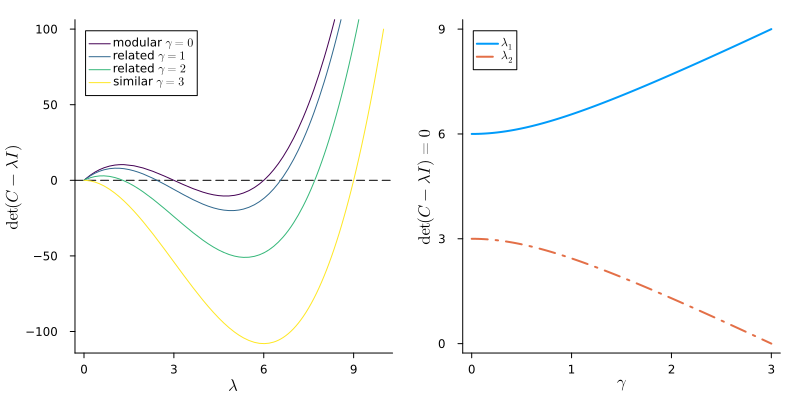

In [8]:
#| echo: false
#| fig-cap: |-
#|   (left) Characteristic polynomial at
#|   3 different degrees of relatedness between organisms.
#|   (right) Roots of the characteristic polynomial while smoothly varying $γ$
#| label: fig-detbylambdaandgamma
using Symbolics
@variables λ γ
γsq = γ^2
p = (3 - λ)^3 - 9*(3 - λ) - γsq * (3 - λ) - γsq * (3 - λ) + 3* γsq + 3*γsq
f = eval(build_function(expand(-p), λ, γ))
cols = permutedims(palette(:viridis, 4).colors.colors)
plot(grid=false, 
    tickdirection=:out, label="", 
    ylims=(-Inf, 100), widen=true,
    ylabel=L"\det(C-λI)",
    xlabel=L"λ",
    xticks=0:3:9,
)
hline!([0], c=:black, linestyle=:dash, label="")
plot!(x->f(x, 0), -.001, 10, c=cols[1], label="modular " * L"γ=0")
plot!(x->f(x, 1), -.001, 10, c=cols[2], label="related " * L"γ=1")
plot!(x->f(x, 2), -.001, 10, c=cols[3], label="related " * L"γ=2")
p1 = plot!(x->f(x, 3), -.001, 10, c=cols[4], label="similar " * L"γ=3")


function get_vals(g)
    m = [
        3 g g
        g 3 3
        g 3 3
    ]
    lambdas = eigvals(m)
    sort(lambdas, rev=true)'
end
plot(grid=false, 
    tickdirection=:out, label="", 
    # ylims=(-Inf, 100), widen=true,
    ylabel=L"\det(C-λI) = 0",
    xlabel=L"\gamma",
    yticks=0:3:9,
)
xs = 0:.01:3
p2 = plot!(xs, vcat(get_vals.(xs)...)[:,1:2], 
    linestyle=[:solid :dashdot],
    labels=[L"λ_1" L"λ_2"],
    lw=2,
)

plot(p1, p2, size=(800, 400), margin=3Plots.Measures.mm)

We see that if we start with the characteristic polynomial including the degree of relatedness variable $\gamma$.

$$
\lambda^3 - 9\lambda^2 + (18 - 2\gamma^2)\lambda
$$

We can immediately factor out a root and power of $\lambda$.

$$
(\lambda - 0)(\lambda^2 - 9\lambda^1 + (18 - 2\gamma^2))
$$
 

This is the third root of the eigenvalue problem and it is always equal to zero because we have set this example with $a$ and $b$ as identical. 

Factoring out this root allows us to use the quadratic formula for the roots on the remaining 2nd order polynomial:

$$
\frac{-b \pm \sqrt{b^2 - 4ac}}{2a} \rightarrow \frac{9 \pm \sqrt{81 - 4(18 - 2\gamma^2)}}{2} = \frac{9 \pm \sqrt{8\gamma^2 + 9}}{2}
$$

Here we see that the remaining two roots are generically expressed using quadratic formula

$$
(\lambda - 0)\left(\lambda - \frac{9 - \sqrt{8\gamma^2 + 9}}{2}\right)\left(\lambda - \frac{9 + \sqrt{8\gamma^2 + 9}}{2}\right)
$$

Because $\sqrt{8\gamma^2 + 9}$ will always be smaller than $9$ while $\gamma < (\langle a|a\rangle = 3)$, we can see that as $\gamma$ approaches $3$ the roots approach $\{0, 0, +9\}$ respectively. And likewise, as $\gamma$ approaches $0$ the roots approach $\{0, +3, +6\}$. These results make some intuitive sense when looking at @fig-detbylambdaandgamma which plots the determinant value with respect to $\lambda$. When $\gamma$ is large it drives the positive first order term of the polynomial to zero, which means that the negative second order term dominates for the region between $\lambda = 0$ to approximately $\lambda = 6$ until finally the positive third order term overtakes and dominates. In contrast when $\gamma$ is small, the positive first order is present and can dominate the polynomial for small values of $\lambda$ until the higher order terms begin to dominate the polynomial.

We also note two important facts: 

First, the second eigenvalue 

$$\left(\lambda - \frac{9 - \sqrt{8\gamma^2 + 9}}{2}\right)$$

will only equal zero when $\gamma$ is exactly equal to $3=\langle a|a \rangle =\langle b|b \rangle = s$ – only when $c$ is exactly identical to $a$ and $b$. At any point where there is a difference in similarity and relatedness between these subpopulations there will be exactly $2$ eigenvalues, and thus exactly $2$ spectral components. 

Second, the two eigenvalues ('roots') will change in equal and opposite directions as the degree of related $\gamma$ changes. These dynamics are caused because the only occasion of $\gamma$ in the quadratic formula is behind the $\pm$ sign, we can see that as $\gamma$ changes the roots of the characteristic polynomial have to change by the same amount in both the positive and negative directions. We also note that the second eigenvalue very quickly drops off, following a power-law on the order of $\gamma^2$. 

The results in this section support the idea that small eigenvalues—and by extension the spectral components they correspond to—are not noise. Up until sub-populations are exactly equal there are necessarily small spectral components, and because they roots change by at least the order of $\gamma^2$ even not vary related sub-populations can have very spectral components corresponding to eigenvalues with extremely small magnitude.

### Change of eigenvector contributions in a 3x3 ensemble of systems as a function of similarity

 To better understand the relevance of the information being described by these minor spectral components, we computed the contribution of organisms $a$, $b$, and $c$ to eigenvectors $v_1$ and $v_2$, defined by $λ_1$ and $λ_2$ respectively. 
 
 For eigenvector $v_1$, we found that the contribution of $a$ and $b$ is relatively constant while the contribution of $c$ rapidly changes from zero and asymptotically reaches the same constant as $a$ and $b$. In contrast, for eigenvector $v_2$ we found that the contribution of $c$ is relatively constant while the contribution of $a$ and $b$ rapidly changes from zero to asymptotically reach a constant value away from that of $h$.  These results indicate that the eigenvector $v_1$ defines the similarity between $a$, $b$, and $c$, whereas eigenvector $v_2$ defines the difference between $a$, $b$, and $c$. This relationship underlies using the eigenspectrum to define different scales of relatedness and is necessarily true independent of the percent variance harbored by each spectral component.

 Yet, how is it that varying the similarity of $c$ to $a$ and $b$ has different effects on the how each system relates to each other depending on which eigenvector is being considered?

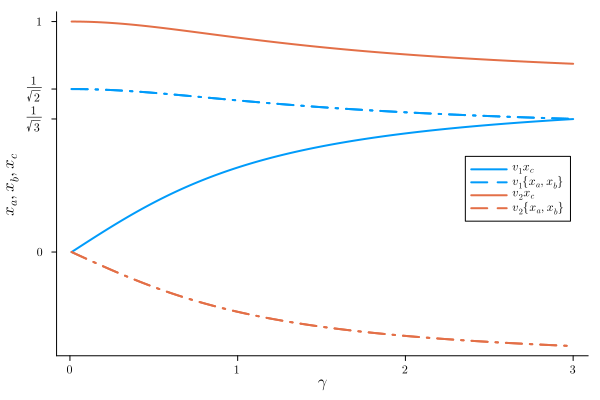

In [10]:
#| echo: false
#| fig-cap: |-
#|   Contribution of organisms onto eigenvectors $v_1$ and $v_2$ as the
#|   degree of relatedness $\gamma$ is varied.
#| label: fig-contributions

function get_vecs(g)
    m = [
        3 g g
        g 3 3
        g 3 3
    ]
    vecs = eigvecs(m)
    v = vecs[:, [3,2]]
    v[:, 1] = sign(v[1, 1]) >= 0 ? v[:, 1] : .-v[:, 1]
    v[:, 2] = sign(v[1, 2]) >= 0 ? v[:, 2] : .-v[:, 2]
    v
end
xs = 0:.01:2.99
pltvecs = permutedims(stack(get_vecs.(xs)), [3,1,2])
plot([0 0 0 0], 
    c=[1 1 2 2], 
    linestyle=[:solid :dash :solid :dash], 
    label=[L"v_1 x_c" L"v_1 \{x_a, x_b\}" L"v_2 x_c" L"v_2 \{x_a, x_b\}"],
    xlabel=L"\gamma",
    ylabel=L"x_a, x_b, x_c",
    # title="Contribution of organisms on eigenvectors",
    legend=:right,
    xticks=([0, 100, 200, 300], [latexstring("$i") for i in 0:3]),
    yticks=([0, 1/sqrt(3), 1/sqrt(2), 1], [L"0", L"\frac{1}{\sqrt{3}}", L"\frac{1}{\sqrt{2}}", L"1"]),
    # yticks=[-.1, 0, 1/sqrt(3), 1/sqrt(2), .9, 1],
    lw=2,
    grid=false,
    tickdir=:out,
)
plot!(pltvecs[:,:,1], c=1, lw=2, linestyle=[:solid :dashdot :dashdot], label="")
plot!(pltvecs[:,:,2], c=2, lw=2, linestyle=[:solid :dashdot :dashdot], label="")

We sought to understand why changing the similarity of $c$ to $a$ and $b$ differentially affects the contribution of each system to eigenvectors $v_1$ and $v_2$. Solving the eigenvectors for the set of eigenvalues defines a system of equations relating the contribution of each system to eigenvectors $v_1$ and $v_2$ and the similarity of $c$ to $a$ and $b$. The eigenvector equation $(C-\lambda I)\vec{v} = 0$ expanded into matrix notation is

$$
\begin{bmatrix}
    \langle c|c \rangle-\lambda&\gamma&\gamma\\
    \gamma&\langle b|b \rangle-\lambda&s\\
    \gamma&s&\langle a|a \rangle-\lambda\\
\end{bmatrix}\begin{bmatrix}x_c\\x_b\\x_a\end{bmatrix}= \begin{bmatrix}0\\0\\0\end{bmatrix}
$$ {#eq-eigenvectormatrix}

We are interested in how the contributions $\{x_a, x_b, x_c\}$ of each organism change with respect to $\gamma$. This question necessitates calculating the partial derivative of the contribution of each system onto either eigenvector $v_1$ or $v_2$ with respect to the similarity of $c$ to $a$ and $b$. We choose to calculate the derivative for each organism's contribution starting at the modular example where the sub-populations are completely independent, $\gamma = 0$

To calculate these derivatives it will be helpful to first calculate the contribution of each organism at the modular case and for comparison at the similar case so that we have concrete numbers that we can substitute into the different variables.

#### Modular case: eigenvector $v_1$

we can start with the modular case's set of equations.

$$
\begin{bmatrix}
    3-\lambda&0&0\\
    0&3-\lambda&3\\
    0&3&3-\lambda\
\end{bmatrix}\begin{bmatrix}x_c\\x_b\\x_a\end{bmatrix}= \begin{bmatrix}0\\0\\0\end{bmatrix}
$$

And then substitute the first root in the modular case $\lambda = 6$

$$
\begin{bmatrix}
    -3&0&0\\
    0&-3&3\\
    0&3&-3\\
\end{bmatrix}\begin{bmatrix}x_c\\x_b\\x_a\end{bmatrix}= \begin{bmatrix}0\\0\\0\end{bmatrix}
$$

to solve for $x_c$ we look to the top row's equation

$$
-3x_c + 0x_b + 0x_a = 0
$$

which is solved by setting $x_c = 0$

the equations for $x_b$ and $x_a$ work together to show that they can equal any real number so long as $x_a = x_b$ 

$$
3x_a - 3x_b = x_a - x_b = 0
$$

so to make $[x_c,x_b,x_a]^t$ a unitary vector (i.e., with length equal to $1$), we set $x_a = x_b = \frac{1}{\sqrt{2}}$


#### Modular case: eigenvector $v_2$
We can use the same process to find the contribution of each organism onto the second eigenvector with $\lambda = 3$

$$
\begin{bmatrix}
    0&0&0\\
    0&0&3\\
    0&3&0\\
\end{bmatrix}\begin{bmatrix}x_c\\x_b\\x_a\end{bmatrix}= \begin{bmatrix}0\\0\\0\end{bmatrix}
$$

to solve for $x_c$ we look to the top equation

$$
0x_c + 0x_b + 0x_a = 0
$$

and see that $x_c$ can be any value. 

the equations for $x_b$ and $x_a$ work together to show that they must both equal zero. 

$$
0x_c + 0x_b + 3x_a = x_a = 0
$$


$$
0x_c + 3x_b + 0x_a = x_b = 0
$$

so to make $[x_c,x_b,x_a]^t$ a unitary vector (i.e., with length equal to $1$), we set $x_a = x_b = 0$ and $x_c = 1$

#### Similar case: eigenvector $v_1$
We also can look to our similar case and find that all contributions are uniformly distributed along the first eigenvector, with no other non-zero eigenvalues or eigenvectors.

$$
\begin{bmatrix}
    -6&3&3\\
    3&-6&3\\
    3&3&-6\\
\end{bmatrix}\begin{bmatrix}x_c\\x_b\\x_a\end{bmatrix}= \begin{bmatrix}0\\0\\0\end{bmatrix}
$$

these are permutations of the same equation

$$
x_a + x_b - 2x_c = 0
$$

$$
x_a + x_c - 2x_b = 0
$$

$$
x_c + x_b - 2x_a = 0
$$

and is solved with $x_c = x_b = x_a$

So, to make $[x_c,x_b,x_a]^t$ a unitary vector, we set $x_a = x_b = x_c = \frac{1}{\sqrt{3}}$

#### Gathering the calculations
After these calculations, we have this table of results showing the contribution of each organism onto eigenvectors both in the modular case and in the similar case

organism contribution | modular <br> $v_1$, $\lambda=6$ | modular <br> $v_2$, $\lambda=3$ | similar <br> $v_1$, $\lambda=9$  | similar <br> $v_2$, $\lambda=0$
---|---|---|---|---
$x_c$ | $0$ | $1$ | $\frac{1}{\sqrt{3}}$ | $0$
$x_b$ | $\frac{1}{\sqrt{2}}$ | $0$ | $\frac{1}{\sqrt{3}}$ | $0$
$x_a$ | $\frac{1}{\sqrt{2}}$ | $0$ | $\frac{1}{\sqrt{3}}$ | $0$

These are the two extreme cases where the sub-populations are either completely distinct or completely identical. And what we see is that in the distinct case the contributions of each sub-population are partitioned onto separate eigenvalues, such that the larger sub-population $\{a, b\}$ is on the larger eigenvector with no contribution from the smaller sub-population $c$. Conversely, the smaller sub-population's contribution is completely on the smaller eigenvector $v_2$ with no contribution from the larger sub-population. Thus, once we have increased the degree of relatedness $\gamma$ to the point both sub-populations are identical, the contribution of each organisms is uniformly weighted on the first eigenvector.

We can now get a sense of what the contributions mean and how different behavior arises on each eigenvector by exploring how the contributions change as we move away from the modular case by increasing the degree of relatedness $\gamma$. Answering this question entails calculating the partial derivatives of $\{x_a, x_b, x_c\}$ with respect to $\gamma$. We will perform this calculation across both eigenvectors $v_1$ and $v_2$.
 

#### partial derivative: $\frac{\partial x_c}{\partial \gamma}$
Let's start with $x_c$

On both $v_1$ and $v_2$ we will need to solve this equation.

$$
(\langle c|c \rangle-\lambda)x_c + \gamma x_b + \gamma x_a = 0
$$

we can isolate $x_c$

$$
\begin{align}
(\langle c|c \rangle-\lambda)x_c + \gamma x_b + \gamma x_a &= 0 \\
(\langle c|c \rangle-\lambda)x_c &= -(\gamma x_b + \gamma x_a)\\
x_c &= \frac{-\gamma(x_b + x_a)}{(\langle c|c \rangle-\lambda)}\\
x_c &= \frac{\gamma(x_b + x_a)}{\lambda - \langle c|c \rangle}\\
\end{align}
$$

Because we are starting from the modular case:

* on $v_1$ we know that $x_a = x_b = \frac{1}{\sqrt{2}}$
* on $v_2$ we know that $x_a = x_b = 0$

We then get a different partial derivative for each eigenvector; simply from the fact the $x_a$ and $x_b$ zero out the derivative on eigenvector $v_2$ and are non-zero on $v_1$. 

On $v_1$ we can substitute and simplify

$$
\begin{align*}
x_c = \frac{\gamma(x_b + x_a)}{\lambda - \langle c|c \rangle} &= \frac{\gamma(\frac{1}{\sqrt{2}} + \frac{1}{\sqrt{2}})}{\lambda - \langle c|c \rangle} \\
&= \frac{2\gamma}{\sqrt{2}\left(\lambda - \langle c|c \rangle\right)} \\
x_c &= \frac{\sqrt{2}\gamma}{\lambda - \langle c|c \rangle} \\
\end{align*}
$$

On $v_2$ we can substitute and simplify

$$
\begin{align*}
x_c = \frac{\gamma(x_b + x_a)}{\lambda - \langle c|c \rangle} &= \frac{\gamma(0 + 0)}{\lambda - \langle c|c \rangle} \\
x_c &= 0
\end{align*}
$$

#### partial derivative: $\frac{\partial x_b}{\partial \gamma}$, $\frac{\partial x_a}{\partial \gamma}$
In contrast, when we we start with $x_b$'s equation

$$
\gamma x_c + (\langle b|b \rangle-\lambda)x_b + s x_a = 0
$$

And isolate $x_b$

$$
\begin{align}
\gamma x_c + (\langle c|c \rangle-\lambda)x_b + s x_a &= 0\\
x_b &= \frac{-(\gamma x_c + s x_a)}{(\langle b|b \rangle-\lambda)}\\
x_b &= \frac{(\gamma x_c + s x_a)}{\lambda - \langle b|b \rangle}\\
\end{align}
$$


We see that on eigenvector $v_1$, $x_c=0$ so the partial derivative is zeroed out. And on eigenvector $v_2$, because $x_c=1$ the derivative with respect to $\gamma$ is 

$$
\frac{\partial x_b}{\partial \gamma} = \frac{1}{\lambda - \langle b|b \rangle}
$$

Using the exact same procedure as for $x_b$, we find for $x_a$ that its partial derivatives are essentially identical

Pulling together all these partial derivatives we start to see a pattern, and explanation for how contributions of organisms can rise and fall on different eigenvectors

eigenvector | partial derivative $x_c$ | partial derivative $x_b$ | partial derivative $x_a$
---|---|---|---
$\text{eigenvector } v_1$ | $\frac{\partial x_c}{\partial \gamma} = \frac{\sqrt{2}}{\lambda_1 - \langle c|c \rangle}$ | $\frac{\partial x_b}{\partial \gamma} = 0$ | $\frac{\partial x_a}{\partial \gamma} = 0$
$\text{eigenvector } v_2$ |$\frac{\partial x_c}{\partial \gamma} = 0$ |$\frac{\partial x_b}{\partial \gamma} = \frac{1}{\lambda_2 - \langle b|b \rangle}$|$\frac{\partial x_a}{\partial \gamma} = \frac{1}{\lambda_2 - \langle a|a \rangle}$

We find that in the limit of a small increase in similarity of $c$ to $a$ and $b$, the change in the contribution of $c$ to eigenvector $v_1$ is a constant while the that of $a$ and $b$ is zero. In contrast, the change in the contribution of $c$ to eigenvector $v_2$ is zero while that of $a$ and $b$ is a constant. Because $λ_1$ and $λ_2$ trend in opposite directions (and away from the singularity at $\lambda=3$), the contribution of $c$ to eigenvector $v_1$ smoothly tends towards that of $a$ and $b$ thereby defining relative system similarity, while the contributions of $a$ and $b$ to eigenvector $v_2$ smoothly tend away from that of $c$ thereby defining the relative dissimilarity between systems.


## Local parameter sweep

In [17]:
using Gotree_jll, Goalign_jll, SeqGen_jll

treedir = datadir("sims", "localsweep", "trees") |> mkpath

numleaves = [16, 32, 64, 128, 256, 512, 1024]
nfeatures = [16, 32, 64, 128, 256, 512, 1024]
baldepth = Int.(log2.(numleaves));
const seed = 42;

Make randomly generated trees. The branch lengths for each random tree are selected from an exponential distribution and trees from GTDB are selected based on number of leaves an internal node posesses.

In [18]:
# branch lengths for each random tree are selected from an exponential distribution
for (d, nl) in zip(baldepth, numleaves)
    run(pipeline(`$(gotree()) generate balancedtree --seed $(seed) -d $d`,
    `$(gotree()) brlen clear`, 
    `$(gotree()) brlen setmin -l 1.0 -o $(treedir)/balancedtree-t$(nl)-s$(seed).nw`
    ))
end

In [19]:
## Make MSAs from generated trees
msadir = datadir("sims", "localsweep", "MSAs")
rm(msadir, force=true, recursive=true)
mkpath(msadir)

# Nbits = 2 (binary)
for Nf in nfeatures
    mkpath(msadir)
    for f in readdir(treedir)
        fn = first(split(f, "."))
        run(pipeline(`$(seqgen()) -q -z$(seed) -s $(2/Nf) -or -l$Nf -mHKY -f0.5,0.0,0.0,0.5`,
            stdin=joinpath(treedir, f),
            stdout=joinpath(msadir, fn * "-l$Nf-b2.phy")))
    end
end

In [21]:
# Run SpectralInference on balenced trees
inputdir = datadir("sims", "localsweep", "MSAs")
inputfiles = joinpath.(inputdir, readdir(inputdir))
simnames = first.(split.(basename.(inputfiles), "."))
outputdir  = projectdir("_research", "localsweep", "runSPI")
outputdirs = joinpath.(outputdir, simnames)

for (inputfile, simname, outdir) in zip(inputfiles, simnames, outputdirs)
    mkpath(outdir)
    run(pipeline(`julia -t 4 $(projectdir("scripts", "runners", "runSPI.jl")) \
        -i $inputfile \
        -o $outdir \
        --nboot 100`, 
        stdout=joinpath(outdir, "runSPI.out")))
end

  Activating project at `~/projects/Doran_etal_2023`
  Activating project at `~/projects/Doran_etal_2023`
  Activating project at `~/projects/Doran_etal_2023`
  Activating project at `~/projects/Doran_etal_2023`
  Activating project at `~/projects/Doran_etal_2023`
  Activating project at `~/projects/Doran_etal_2023`
  Activating project at `~/projects/Doran_etal_2023`
  Activating project at `~/projects/Doran_etal_2023`
  Activating project at `~/projects/Doran_etal_2023`
  Activating project at `~/projects/Doran_etal_2023`
  Activating project at `~/projects/Doran_etal_2023`
  Activating project at `~/projects/Doran_etal_2023`
  Activating project at `~/projects/Doran_etal_2023`
  Activating project at `~/projects/Doran_etal_2023`
  Activating project at `~/projects/Doran_etal_2023`
  Activating project at `~/projects/Doran_etal_2023`
  Activating project at `~/projects/Doran_etal_2023`
  Activating project at `~/projects/Doran_etal_2023`
  Activating project at `~/projects/Doran_etal

In [33]:
### SPI METRICS
sourcetrees = joinpath.(datadir(), "sims", "localsweep", "trees", replace.(basename.(inputfiles), r"-l[0-9].*"=>".nw"))
metricdf = DataFrame(
    :treefile=>sourcetrees,
    :msafile=>inputfiles,
    :msaname=>simnames,
    :outputdir=>outputdirs,
    :ntaxa=>parse.(Int, replace.(simnames, r"(.*)((?<=-t)[0-9]*)(.*)"=>s"\2")),
    :nfeatures=>parse.(Int, replace.(simnames, r"(.*)((?<=-l)[0-9]*)(.*)"=>s"\2")),
    :nbits=>parse.(Int, replace.(simnames, r"(.*)((?<=-b)[0-9]*)(.*)"=>s"\2")),
)
metricdf = transform(metricdf, :nbits => (x-> x==20 ? "AA" : "DNA") => :chartype)

@info "Reading original source trees for SPI..."
origtrees = readnw.(read.(metricdf.treefile, String));
as_polytomy!.(n->distance(n)<1e-8, origtrees);

predtreesfiles = joinpath.(projectdir(), "_research", "localsweep", "runSPI", metricdf.msaname, metricdf.msaname .* "-supporttree.nw")
@info "Reading in SPI predicted trees..."
predtrees = readnw.(read.(predtreesfiles, String));
as_polytomy!.(n->NewickTree.support(n)<.5, predtrees);
@info "Calculate SPI Fscore Precision & Recall..."
proformencemetrics = fscore_precision_recall.(origtrees, predtrees)
proformencemetrics = hcat(vcat.(proformencemetrics...)...)
metricdf[!,:SPI_fscore] .= proformencemetrics[:, 1]
metricdf[!,:SPI_precision] .= proformencemetrics[:, 2]
metricdf[!,:SPI_recall] .= proformencemetrics[:, 3]

@info "Calculating SPI Branch Depth"
mmmdepths = map(predtrees) do tr
    dists = mapinternalnodes(network_distance, tr, tr)
    return [mean(dists), median(dists), maximum(dists)]
end
mmmdepths = hcat(mmmdepths...)'
metricdf[!,:SPI_meandepth] .= mmmdepths[:, 1]
metricdf[!,:SPI_mediandepth] .= mmmdepths[:, 2]
metricdf[!,:SPI_maxdepth] .= mmmdepths[:, 3]

mkpath(datadir("exp_pro", "localsweep"))
CSV.write(datadir("exp_pro", "localsweep", "metricsSPI.csv"), metricdf)

┌ Info: Reading original source trees for SPI...
└ @ Main /Users/bend/projects/Doran_etal_2023/notebooks/02_figure_02supp.ipynb:14
┌ Info: Reading in SPI predicted trees...
└ @ Main /Users/bend/projects/Doran_etal_2023/notebooks/02_figure_02supp.ipynb:19
┌ Info: Calculate SPI Fscore Precision & Recall...
└ @ Main /Users/bend/projects/Doran_etal_2023/notebooks/02_figure_02supp.ipynb:22
┌ Info: Calculating SPI Branch Depth
└ @ Main /Users/bend/projects/Doran_etal_2023/notebooks/02_figure_02supp.ipynb:29


"/Users/bend/projects/Doran_etal_2023/data/exp_pro/localsweep/metricsSPI.csv"

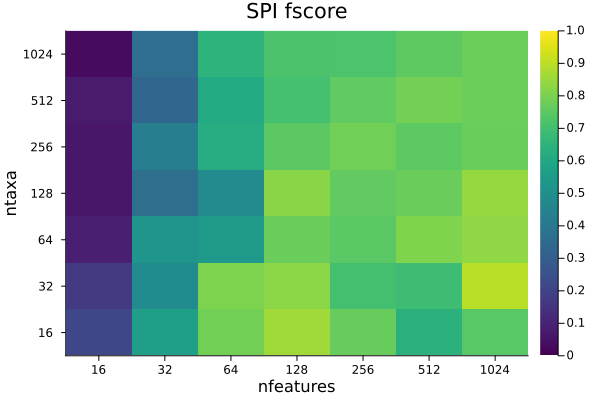

In [34]:
pdir = plotsdir("localsweep")
mkpath(pdir)
df = CSV.read(datadir("exp_pro", "localsweep", "metricsSPI.csv"), DataFrame);
CSV.write(datadir("exp_pro", "localsweep", "TableS1.csv"),
    df[:, [:msaname, :ntaxa, :nfeatures, :chartype, :SPI_fscore, :SPI_recall, :SPI_precision]]
)
pdf = df[:, [:ntaxa, :nfeatures, :SPI_fscore]] |>
    df->unstack(df, :nfeatures, :SPI_fscore) |>
    df->sort(df, :ntaxa) |>
    df->select(df, ["ntaxa", "16", "32","64", "128", "256", "512", "1024"])
heatmap(Matrix(pdf[!,2:end]), 
    ticks=(1:7, [ "16", "32", "64", "128", "256", "512", "1024"]),
    xlabel="nfeatures",
    ylabel="ntaxa",
    clims=(0,1),
    title="SPI fscore",
    c=:viridis)

## Example with convergent evolution

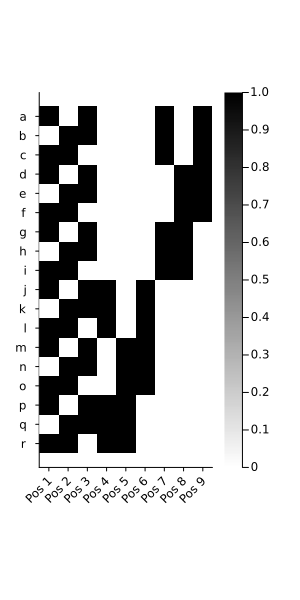

In [2]:
M = Float64.([
    1 0 1 0 0 0 1 0 1;
    0 1 1 0 0 0 1 0 1;
    1 1 0 0 0 0 1 0 1;
    1 0 1 0 0 0 0 1 1;
    0 1 1 0 0 0 0 1 1;
    1 1 0 0 0 0 0 1 1;
    1 0 1 0 0 0 1 1 0;
    0 1 1 0 0 0 1 1 0;
    1 1 0 0 0 0 1 1 0;
    1 0 1 1 0 1 0 0 0;
    0 1 1 1 0 1 0 0 0;
    1 1 0 1 0 1 0 0 0;
    1 0 1 0 1 1 0 0 0;
    0 1 1 0 1 1 0 0 0;
    1 1 0 0 1 1 0 0 0;
    1 0 1 1 1 0 0 0 0;
    0 1 1 1 1 0 0 0 0;
    1 1 0 1 1 0 0 0 0;
]);
heatmap(M, 
    c=[:white, :black], 
    ratio=1, 
    xticks=(1:9, ["Pos $i" for i in 1:9]),
    xrotation=45,
    yticks=(1:18, 'a':'r'),
    yflip=true,
    size=(300, 600),
    margin=5Plots.mm,
)

In [3]:
usv = svd(M);

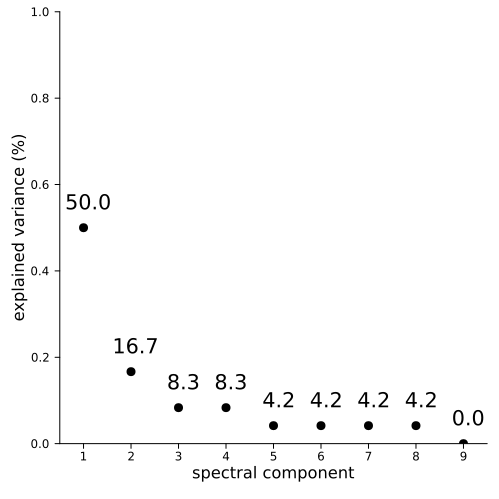

In [4]:
plot(
    ylabel="explained variance (%)", 
    xlabel="spectral component", 
    legend=:none, 
    ylims=(0,1), xlims=(.5,9.5), 
    size=(500,500)
)
scatter!((usv.S.^2)/sum(usv.S.^2), 
    xticks=1:14, c=:black, markersize=5,
)
annotate!((1:length(usv.S)) .+ .1 , (usv.S.^2)/sum(usv.S.^2).+.06, round.((usv.S.^2)/sum(usv.S.^2)*100, digits=1))

### Phylogenetic inference with FastME, PhyML, and SPI

In [5]:
toyMSA_18x9_dir = datadir("sims", "toyMSA_18x9") |> mkpath
# write out alignment
writephylip(
    joinpath(toyMSA_18x9_dir, "MSA.phylip"),
    join.(eachrow((replace(M, 0.0 => 'A', 1.0 => 'T')))),
    collect('a':'r')
)

In [89]:
# FastME
run(`julia $(projectdir("scripts", "runners", "runFastME.jl")) 
    -i $(datadir("sims", "toyMSA_18x9", "MSA.phylip"))
    -o $(projectdir("_research", "toyMSA_18x9", "FastME"))
    -m JC69
`)
# PhyML
run(`julia $(projectdir("scripts", "runners", "runPhyML.jl")) 
    -i $(datadir("sims", "toyMSA_18x9", "MSA.phylip"))
    -o $(projectdir("_research", "toyMSA_18x9", "PhyML"))
    -m JC69
`)
# SpectralInference
run(`julia $(projectdir("scripts", "runners", "runSPI.jl")) 
    -i $(datadir("sims", "toyMSA_18x9", "MSA.phylip"))
    -o $(projectdir("_research", "toyMSA_18x9", "SPI"))
    -m JC69
`);
pdir_toyMSA_18x9 = plotsdir("toyMSA_18x9") |> mkpath

  Activating

 project at `~/projects/Doran_etal_2023`


[ Info: Starting FastME on MSA


[ Info: using Booster to compute support values


[ Info: stopping run
 ──────────────────────────────────────────────────────────────────────
                              Time                    Allocations      
                     ───────────────────────   ────────────────────────
  Tot / % measured:       547ms /  91.1%           51.6MiB /  89.7%    

 Section     ncalls     time    %tot     avg     alloc    %tot      avg
 ──────────────────────────────────────────────────────────────────────
 total            1    498ms  100.0%   498ms   46.3MiB  100.0%  46.3MiB
   booster        1    217ms   43.7%   217ms   1.16MiB    2.5%  1.16MiB
   FastME         1    161ms   32.2%   161ms   3.29MiB    7.1%  3.29MiB
 ──────────────────────────────────────────────────────────────────────
┌ Info: timing
│   show(time) = nothing
└   println("") = nothing


  Activating

 project at `~/projects/Doran_etal_2023`


[ Info: Starting PhyML on MSA


[ Info: stopping run
 ────────────────────────────────────────────────────────────────────
                            Time                    Allocations      
                   ───────────────────────   ────────────────────────
 Tot / % measured:      371ms /  87.0%           50.1MiB /  89.4%    

 Section   ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────
 total          1    323ms  100.0%   323ms   44.8MiB  100.0%  44.8MiB
   PhyML        1    188ms   58.2%   188ms   2.97MiB    6.6%  2.97MiB
 ────────────────────────────────────────────────────────────────────
┌ Info: timing
│   show(time) = nothing
└   println("") = nothing


  Activating

 project at `~/projects/Doran_etal_2023`


[ Info: Starting SPI inference
[ Info: Setting up workspace
[ Info: Running SPI


[ Info: Writing out SPI Tree
[ Info: Starting Bootstrap with 100


[ Info: Writing out Bootstrap trees
[ Info: using Booster to compute support values


[ Info: Finishing run
 ────────────────────────────────────────────────────────────────────────────────
                                        Time                    Allocations      
                               ───────────────────────   ────────────────────────
       Tot / % measured:            1.58s /  96.4%            289MiB /  98.0%    



 Section               ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────────────────
 total                      1    1.52s  100.0%   1.52s    283MiB  100.0%   283MiB
   running SPI              1    874ms   57.5%   874ms    161MiB   57.0%   161MiB
   running bootstra...      1    172ms   11.3%   172ms   67.8MiB   24.0%  67.8MiB
 ────────────────────────────────────────────────────────────────────────────────
┌ Info: 
│ timing
│   show(time) = nothing
└   println("") = nothing


"/Users/bend/projects/Doran_etal_2023/plots/toyMSA_18x9"

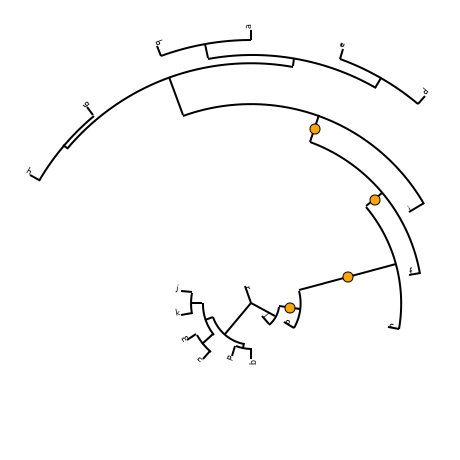

In [90]:
method = "FastME"
run(pipeline(`$(gotree()) draw svg -c -w 400 -H 400 --support-cutoff .5 --with-branch-support`,
    stdin=projectdir("_research", "toyMSA_18x9", method, "MSA-supporttree.nw"),
    stdout=joinpath(pdir_toyMSA_18x9, method * ".svg")
))
show_svg(joinpath(pdir_toyMSA_18x9, method * ".svg"))

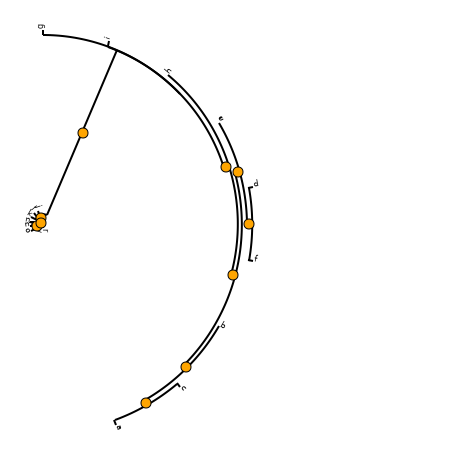

In [91]:
method = "PhyML"
run(pipeline(`$(gotree()) draw svg -c -w 400 -H 400 --support-cutoff .5 --with-branch-support`,
    stdin=projectdir("_research", "toyMSA_18x9", method, "MSA.phylip-supporttree.txt"),
    stdout=joinpath(pdir_toyMSA_18x9, method * ".svg")
))
show_svg(joinpath(pdir_toyMSA_18x9, method * ".svg"))

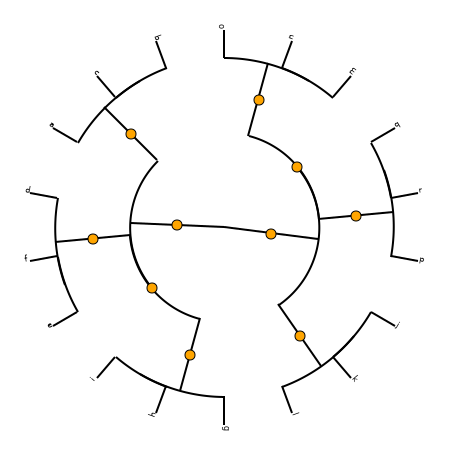

In [92]:
method = "SPI"
run(pipeline(`$(gotree()) draw svg -c -w 400 -H 400 --support-cutoff .5 --with-branch-support`,
    stdin=projectdir("_research", "toyMSA_18x9", method, "MSA-supporttree.nw"),
    stdout=joinpath(pdir_toyMSA_18x9, method * ".svg")
))
show_svg(joinpath(pdir_toyMSA_18x9, method * ".svg"))

### How is information encoded about convergent processes?

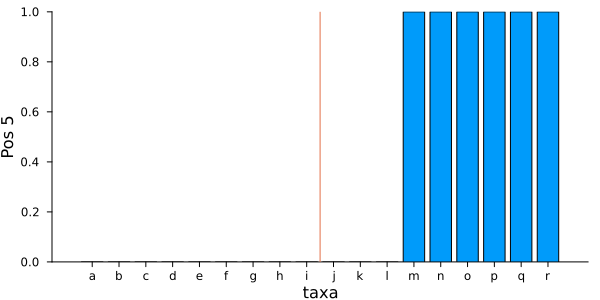

In [7]:
bar(M[:, 5],
    xticks=(1:18, 'a':'r'),
    xlabel="taxa",
    ylabel="Pos 5",
    size=(600, 300),
)
vline!([9.5])

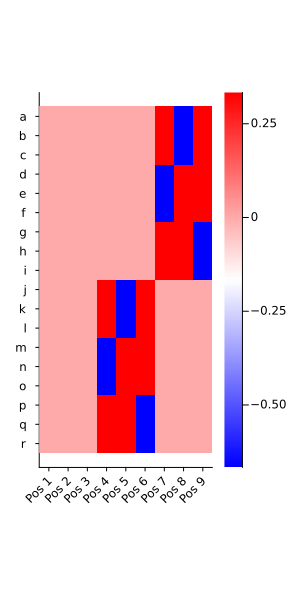

In [6]:
Mspectrallyfiltered = usv.U[:, 5:8] * Diagonal(usv.S[5:8]) * usv.Vt[5:8, :]
heatmap(Mspectrallyfiltered, 
    c=:bwr, 
    ratio=1, 
    xticks=(1:9, ["Pos $i" for i in 1:9]),
    xrotation=45,
    yticks=(1:18, 'a':'r'),
    yflip=true,
    size=(300, 600),
    margin=5Plots.mm,
)

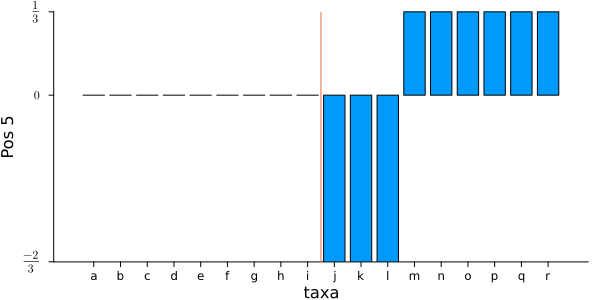

In [7]:
bar(Mspectrallyfiltered[:, 5],
    xticks=(1:18, 'a':'r'),
    xlabel="taxa",
    ylabel="Pos 5",
    size=(600, 300),
    ylims=(-.6667, .33334),
    widen=true,
    yticks=([-0.666, 0.0, .3333], [L"\frac{-2}{3}", L"0", L"\frac{1}{3}"])
)
vline!([9.5])

In [8]:
spectralcorrs = map([i:(i+2) for i in 1:(size(M,2)-2)]) do window
    spectralcorrelations(usv.U, window)
end;

F1mask = kron([1 0; 0 1], ones(3,3), ones(3,3))
F2mask = kron(Diagonal(ones(6)), ones(3,3));
uppertriangle = triu(trues(18, 18), 1);

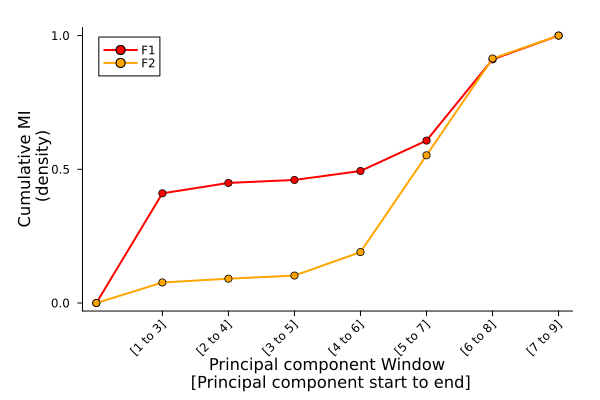

In [9]:
f1mi = map(spectralcorrs) do spcorr 
    empiricalMI(spcorr[uppertriangle], (F1mask .== 1)[uppertriangle]) # edges=-1:0.001:1
end
f2mi = map(spectralcorrs) do spcorr 
    empiricalMI(spcorr[uppertriangle], (F2mask .== 1)[uppertriangle]) # edges=-1:0.001:1
end

plot(
    ylabel="Cumulative MI\n (density)",
    xlabel="Principal component Window\n [Principal component start to end]",
    yticks=[0.0, .5, 1.0],
    xticks=(2:8, ["[$i to $(i+2)]" for i in 1:7]),
    xrotation=45,
    margin=5Plots.mm,
)
plot!(scaledcumsum(vcat(0, f1mi)), c=:red, marker=true, label="F1", lw=2,)
plot!(scaledcumsum(vcat(0, f2mi)), c=:orange, marker=true, label="F2", lw=2,)

## Timing benchmark

In [15]:
## create UniProt subsets
uniprot = readh5ad(datadir("exp_raw", "UP7047", "2020_02_UP7047.h5ad"))
rowmeta = uniprot.obs;

outdir = datadir("exp_pro", "UPsubsetMSAs") |> mkpath

"/Users/bend/projects/Doran_etal_2023/data/exp_pro/UPsubsetMSAs"

### Subset to different number of taxa

* 25 taxa at Genus level (Ruminococcus)
* 50 taxa at Family level (Rhodospirillaceae)
* 103 taxa at Order level (Oceanospirillales)
* 211 taxa at Class level (Bacteroidia)

In [19]:
#| code-fold: true
#| code-summary: write out each subset as pseudo-alignment

## Genus
genus_choice_df = combine(nrow, groupby(rowmeta, :Genus)) |>
    df->sort(df, :nrow, rev=true) |>
    df->filter(:nrow=>x->24 .< x .< 27, df)
display(genus_choice_df)

mask = findall(==("Ruminococcus"), rowmeta.Genus);
subsetMSA = Char.(replace(uniprot.X[mask, :] .> 0.0, true=>'T', false=>'A'))
open(joinpath(outdir, "UPsubset_taxa=25_level=Genus_group=Ruminococcus_alphabet=AT.phy"), "w") do io
    println(io, size(subsetMSA, 1), " ", size(subsetMSA, 2))
    for (id, row) in zip(rowmeta.proteomeID[mask], eachslice(subsetMSA, dims=1))
        println(io, id, "    ", join(row))
    end
end

## Family
family_choice_df = combine(nrow, groupby(rowmeta, :Family)) |>
    df->sort(df, :nrow, rev=true) |>
    df->filter(:nrow=>x->48 .< x .< 52, df)
display(family_choice_df)

mask = findall(==("Rhodospirillaceae"), rowmeta.Family);
subsetMSA = Char.(replace(uniprot.X[mask, :] .> 0.0, true=>'T', false=>'A'))
open(joinpath(outdir, "UPsubset_taxa=50_level=Family_group=Rhodospirillaceae_alphabet=AT.phy"), "w") do io
    println(io, size(subsetMSA, 1), " ", size(subsetMSA, 2))
    for (id, row) in zip(rowmeta.proteomeID[mask], eachslice(subsetMSA, dims=1))
        println(io, id, "    ", join(row))
    end
end

## Order
order_choice_df = combine(nrow, groupby(rowmeta, :Order)) |>
    df->sort(df, :nrow, rev=true) |>
    df->filter(:nrow=>x->95 .< x .< 105, df)
display(order_choice_df)

mask = findall(==("Oceanospirillales"), rowmeta.Order);
subsetMSA = Char.(replace(uniprot.X[mask, :] .> 0.0, true=>'T', false=>'A'))
open(joinpath(outdir, "UPsubset_taxa=103_level=Order_group=Oceanospirillales_alphabet=AT.phy"), "w") do io
    println(io, size(subsetMSA, 1), " ", size(subsetMSA, 2))
    for (id, row) in zip(rowmeta.proteomeID[mask], eachslice(subsetMSA, dims=1))
        println(io, id, "    ", join(row))
    end
end

## Class
class_choice_df = combine(nrow, groupby(rowmeta, :Class)) |>
    df->sort(df, :nrow, rev=true) |>
    df->filter(:nrow=>x->190 .< x .< 215, df)
display(class_choice_df)

mask = findall(==("Bacteroidia"), rowmeta.Class);
subsetMSA = Char.(replace(uniprot.X[mask, :] .> 0.0, true=>'T', false=>'A'))
open(joinpath(outdir, "UPsubset_taxa=211_level=Class_group=Bacteroidia_alphabet=AT.phy"), "w") do io
    println(io, size(subsetMSA, 1), " ", size(subsetMSA, 2))
    for (id, row) in zip(rowmeta.proteomeID[mask], eachslice(subsetMSA, dims=1))
        println(io, id, "    ", join(row))
    end
end

Row,Genus,nrow
,String,Int64
1,Helicobacter,26
2,Ruminococcus,25


Row,Family,nrow
,String,Int64
1,Alteromonadaceae,51
2,Rhodospirillaceae,50


Row,Order,nrow
,String,Int64
1,Oceanospirillales,103
2,Pseudomonadales,97


Row,Class,nrow
,String,Int64
1,Bacteroidia,211


In [ ]:
## submit job to cluster to run all phylogenetic inference tasks in parallel
# run(`sbatch $(projectdir("scripts", "slurm-run-PI-on-UPsubsets.sbatch"))`)

In [21]:
time_per_run_df = CSV.read(projectdir("_research", "UPsubsetMSAs", "timeperjob.log"), DataFrame, delim="\t");

In [24]:
pltdf = sort(time_per_run_df, :Seq) |>
    df->filter(:Exitval=> ==(0), df) |>
    df->transform(df, :Command=>(x->replace.(x, r"(.*)((?<=\/t)[0-9]*)(.*)"=>s"\2"))=> :Ntaxa ) |>
    df->transform(df, :Command=>(x->replace.(x, r"(.*)((?<=runners\/run)[a-zA-Z]*)(.*)"=>s"\2"))=> :method);

pltdf = pltdf[:, [:method, :Ntaxa, :JobRuntime]];
pltdf.Ntaxa = parse.(Int, pltdf.Ntaxa);
pltdf = sort(pltdf, [:method, :Ntaxa]);
pltdf

Row,method,Ntaxa,JobRuntime
,String,Int64,Float64
1,FastME,25,12.075
2,FastME,50,15.401
3,FastME,103,36.002
4,FastME,211,142.682
5,FastTree,25,883.487
6,FastTree,50,2011.95
7,FastTree,103,4044.1
8,FastTree,211,6906.7
9,MrBayes,25,728.282


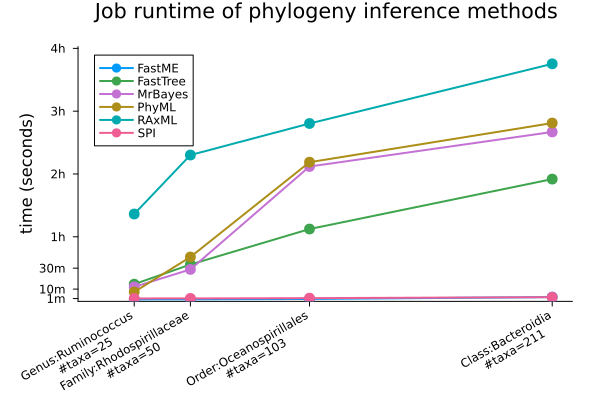

In [27]:
plot(title="Job runtime of phylogeny inference methods",
    ylabel="time (seconds)",
    yticks=([60, 600, 1800, 3600, 7200, 10800, 14400], ["1m", "10m", "30m", "1h", "2h", "3h", "4h"]),
    xticks=([25, 50, 103, 211], [
        "Genus:Ruminococcus\n #taxa=25",
        "Family:Rhodospirillaceae\n #taxa=50",
        "Order:Oceanospirillales\n #taxa=103",
        "Class:Bacteroidia\n #taxa=211",
         ]),
    xrotation=30,
    margin=5Plots.Measures.mm,
    ylims=(-100, 14500),
    xlims=(0, 220),
    legend=:topleft,
)
@df pltdf plot!(:Ntaxa, :JobRuntime, group=:method, markers=true,
    linewidth=2,
    markersize=6,
    markerstrokewidth=0,
    c=permutedims(vcat([1],3:7)))